## Instructions

**Programming project: probability of death**

Length of stay prediction
In this project, you have to predict the length of stay (in days) of a patient that is entering an ICU (Intensive Care Unit) using decision tree models.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of mimic_train.csv corresponds to one ICU stay (hadm_id+ icustay_id) of one patient (subject_id). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise. The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at mimic_patient_metadata.csv.

Please don't use any feature that you infer you don't know the first day of a patient in an ICU, e.g. HOSPITAL_EXPIRE_FLAG

Note that the main cause/disease of patient condition is embedded as a code at ICD9_diagnosis column. The meaning of this code can be found at MIMIC_metadata_diagnose.csv. But this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at extra__data/MIMIC_diagnoses.csv.

As performance metric, please use RMSE (root mean squared error).

Main tasks are:

Using mimictrain.csv file build a predictive model for *HOSPITALEXPIRE_FLAG *.
For this analysis there is an extra test dataset, mimictestlos.csv. Apply your final model to this extra dataset and generate predictions following the same format as mimickagglelossamplesubmission.csv. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.
As a bonus, try different decision trees algorithms, even combine with other prediction models. Try to assess which features are more important, and if possible the confidence interval of predictions.

You can follow those steps in your first implementation:

Explore and understand the dataset.
Manage missing data.
Manage categorical features. E.g. create dummy variables for relevant categorical features, or build an ad hoc distance function.
Build a prediction model
Assess expected accuracy of previous models using cross-validation.
Predict on the test file, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset. Submit to Kaggle to check performance.

# Helper Functions and Imports


In [ ]:
#Imports
import pandas as pd
from pandas import Series

import numpy as np
from numpy.random import randn

#Visualization
import seaborn as sns
!pip install dexplot
import dexplot as dxp
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import colors

import time

#For boxcox
import scipy
from scipy import stats as st
from scipy.stats import boxcox
from scipy.special import inv_boxcox

#Sklearn
import sklearn 
from sklearn import preprocessing, impute, svm, datasets
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder
#Potentially needed
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn import set_config

#For ensemble
#!pip install mlens
import mlens
from mlens.ensemble import SuperLearner
import pickle
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble

#Xgboost
import xgboost
from xgboost import XGBRegressor, XGBClassifier

from IPython.display import Image 
import pydotplus
import graphviz

#For categorical transformation
!pip install category_encoders
import category_encoders as ce
from category_encoders import WOEEncoder, TargetEncoder, HashingEncoder, BinaryEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

#Neural Nets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import os
import tarfile
import imageio
import tqdm

import random
import ipywidgets

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip install lime
!pip install shap
import shap
import lime

#pd.set_option("display.max_rows", None, "display.max_columns", None)
#pd.reset_option('all')

#Set seed
SEED = 238

In [ ]:
#Functions
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

def feature_impact(x, regression):
  feature_impact = pd.DataFrame({"Feature":x.columns.tolist(),"Coefficients":regression.coef_[0]})
  print(feature_impact.plot.bar(x='Feature', y='Coefficients', color='green'))
  return feature_impact

def binary_classifier(regression, x, y, test):
    regression.fit(x, y)
    y_hat = regression.predict(x)
    #Turn back into df
    y_hat = pd.DataFrame(y_hat, columns = ['Y Prediction'])
    print("TRAIN PREDICTIONS")
    print(y_hat)

    #Do same for testing set predictions
    print("TEST PREDICTIONS")
    pred_test = regression.predict(test)
    pred_test = pd.DataFrame(pred_test, columns = ['Y Prediction Test'])
    print(pred_test)
    
    return y_hat, pred_test

def evaluate(title, regression, X_train, y, y_pred):
    #title is a string denoting the type of data being used (i.e. undersample, oversample)
    
    #regression_acc * 100 because want to see as percentage
    y_pred = regression.predict(X_train)
    regression_acc = regression.score(X_train, y_pred)
    print("Accuracy ({}): {:.2f}%".format(title, regression_acc * 100))
    #from sklearn.metrics import confusion_matrix
    cf_matrix = confusion_matrix(y, y_pred)
    clr = classification_report(y, y_pred)
    #classification report is also useful to compare
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='winter')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Long','Short'])
    ax.yaxis.set_ticklabels(['Long','Short'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    

    print("Classification Report:\n----------------------\n", clr)

    #get_auc(y["Not Target", "Target"], column=1, plot=True) # Help function

    #Precision recall curve, which is appropriate for an imbalanced data set.
    #from sklearn.metrics import PrecisionRecallDisplay

    display = PrecisionRecallDisplay.from_estimator(
      regression, X_train, y, name="LinearSVC"
      ) 
    _ = display.ax_.set_title("2-class Precision-Recall curve")

def evaluate_three(title, regression, X_train, y, y_pred):
    #title is a string denoting the type of data being used (i.e. undersample, oversample)
    
    #regression_acc * 100 because want to see as percentage
    y_pred = regression.predict(X_train)
    regression_acc = regression.score(X_train, y_pred)
    print("Accuracy ({}): {:.2f}%".format(title, regression_acc * 100))
    cf_matrix = confusion_matrix(y, y_pred)
    clr = classification_report(y, y_pred)
    #classification report is also useful to compare
    
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='viridis')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Long', 'Medium', 'Short'])
    ax.yaxis.set_ticklabels(['Long','Medium', 'Short'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    

    print("Classification Report:\n----------------------\n", clr)

    #get_auc(y["Not Target", "Target"], column=1, plot=True) # Help function

    #Precision recall curve, which is appropriate for an imbalanced data set.
    #from sklearn.metrics import PrecisionRecallDisplay

    display = PrecisionRecallDisplay.from_estimator(
      regression, X_train, y, name="LinearSVC"
      ) 
    _ = display.ax_.set_title("2-class Precision-Recall curve")

def submission(predictions, submission_filename):
  test_predictions_submit = predictions.copy()
  test_predictions_submit['icustay_id'] = test["icustay_id"]
  #reverse columns
  test_predictions_submit = test_predictions_submit.iloc[:, ::-1]
  return test_predictions_submit.to_csv(submission_filename, index = False)

#Create function for submitting to Kaggle
def submission_fromnp(predictions, submission_filename):
  test_predictions = predictions.copy()
  test_predictions_submit = pd.DataFrame({"icustay_id": test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": pred_test_prob})
  return test_predictions_submit.to_csv(submission_filename, index = False)


def log_transform(feature):
    train_raw[feature] = np.log1p(train_raw[feature].values)
    test_raw[feature] = np.log1p(test_raw[feature].values)

def quadratic(feature):
    train_raw[feature+'sq'] = train_raw[feature]**2
    test_raw[feature+'sq'] = test_raw[feature]**2

def plot_tree(clf, feature_names, target_names):
    dot_data = sklearn.tree.export_graphviz(clf, out_file=None, 
                             feature_names=feature_names,  
                             class_names= target_names,  
                             filled=True, rounded=True,  
                             special_characters=True) 
    return pydotplus.graph_from_dot_data(dot_data).create_png() 

def plot_confusion_matrix(cm, class_labels):
    """Pretty prints a confusion matrix as a figure

    Args:
        cm:  A confusion matrix for example
        [[245, 5 ], 
         [ 34, 245]]
         
        class_labels: The list of class labels to be plotted on x-y axis

    Rerturns:
        Just plots the confusion matrix.
    """
    
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel("Predicted label")
    plt.ylabel("Real label")
    plt.show()


   
def plot_any_cat_matrix(dat,Yvar,Xvar, width=10, height=10):
    """Pretty prints a categorical matrix of counts as a figure

    Args:
        dat:  A data frame, each row is an observation, and has more than one categorical feature
        Yvar: Categorical variable name, should exist in dat
        Xvar: Categorical variable name, should exist in dat


    Rerturns:
        Just plots the occurence matrix.
    """
    
    aux=dat[[Xvar,Yvar]].groupby([Xvar,Yvar]).size()
    aux=pd.DataFrame(aux)
    aux.reset_index(level=0, inplace=True)
    aux.reset_index(level=0, inplace=True)
    aux

    counts= aux.pivot_table(index=Yvar, columns=Xvar,fill_value=0)
    counts.columns= counts.columns.droplevel( level=0)

    fig, ax = plt.subplots(figsize=(width,height))
    sns.set(font_scale=0.7)
    sns.heatmap(counts, annot=True, fmt='g', cmap='Blues', ax=ax)
    plt.xlabel(Xvar)
    plt.ylabel(Yvar)
    plt.show()
    
    
from sklearn.metrics import roc_curve, roc_auc_score
def get_auc(y, y_pred_probabilities, class_labels, column =1, plot = True):
    """Plots ROC AUC
    """
    fpr, tpr, _ = roc_curve(y == column, y_pred_probabilities[:,column],drop_intermediate = False)
    roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities[:,1])
    print ("AUC: ", roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#import random
def plot_digits_sample(images, target, labels = None):
    # The data that we are interested in is made of 8x8 images of digits, let's
    # have a look at the first images, stored in the `images` attribute of the
    # dataset.  If we were working from image files, we could load them using
    # matplotlib.pyplot.imread.  Note that each image must have the same size. For these
    # images, we know which digit they represent: it is given in the 'target' of
    # the dataset.
    

    fig, axes = plt.subplots(5, 5, figsize=(5, 5),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))

    for i, ax in enumerate(axes.flat):
        im = random.randint(0, len(images)-1)
        ax.imshow(images[im].reshape([8,8]), cmap=plt.cm.gray_r, interpolation='nearest')
        ax.text(0.05, 0.05, str(target[im]),
                transform=ax.transAxes, color='green')

    plt.show()

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """ Convenience function to plot results and buffers, extracted from Python Data Science Handbook
    Used for SVM notebook
    """
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black', facecolors='None');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)



def Plot_Point(X,y,Target,Neighbors, ax=None):
    """ Plots sample observation, Targets and some Neighors
    Used for K-NN
    """
    
    if (ax==None):
        fig,ax = plt.subplots()

    scatter=plt.scatter(X[:, 0], X[:, 1], c=y, s=50 , cmap='rainbow');
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Classes")
    ax.scatter(Target[0][0],Target[0][1], s=100, linewidth=1, edgecolors='black', facecolors='black');
    ax.scatter(Neighbors[:,0],Neighbors[:,1], s=200, linewidth=1, edgecolors='black', facecolors='None');
    
    
def predict(regressor, xtrain, xtest, y, csv_string):

  # Fit on training data with y_log in first attempt
  model = regressor.fit(xtrain, y)

  pred = model.predict(xtest)

  test_predictions_submit = pd.DataFrame({"icustay_id": test_long["icustay_id"], "LOS": pred})

  return test_predictions_submit.to_csv(csv, index = False)


def predictbox(regressor, xtrain, xtest, y, csv):

  y_box, lambda_box = st.boxcox(y)

  # Fit on training data with y_log in first attempt
  model = regressor.fit(xtrain, y_box)

  pred = model.predict(xtest)

  submission_bcx = inv_boxcox(pred, lambda_box)

  test_predictions_submit = pd.DataFrame({"icustay_id": raw_test["icustay_id"], "LOS": submission_bcx})
  return test_predictions_submit.to_csv(csv, index = False)
   
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          table=True,
                          display_all_params=True):

    '''Display grid search results
    modified from https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search
    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    table              boolean: should a table be produced?
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    #from matplotlib      import pyplot as plt
    #from IPython.display import display
    #import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_


    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
    scores_df = scores_df[scores_df.columns.drop(list(scores_df.filter(regex='time')))] #drop time parameters

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    if table:
        display(scores_df \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()
  

def cfmatrix(cf_matrix, ytest, yhat, classlabels):
    cf_matrix =  confusion_matrix(ytest, yhat)

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    fig, ax = plt.subplots(figsize=(15,10)) 
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='summer')

    ax.set_title('Random Forest Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted')
    ax.set_ylabel('Actual');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(classlabels)
    ax.yaxis.set_ticklabels(classlabels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

def LeakyReLU(x, a):
  return np.where(x >= 0, x, a*x) 

def drop_ids(Train, Test):
  Train_ = Train.drop(["hadm_id",	"icustay_id", "subject_id"], axis=1)
  Test_ = Test.drop(["hadm_id",	"icustay_id", "subject_id"], axis=1)
  return Train_, Test_

def drop_ids_and_los(Train):
  Train_ = Train.drop(["hadm_id",	"icustay_id", "subject_id", "LOS", "LOS_deciles","LOS_qtiles"], axis=1)
  return Train_

def drop_sub_id(Train, Test):
  Train_ = Train.drop(["subject_id"], axis=1)
  Test_ = Test.drop(["subject_id"], axis=1)
  return Train_, Test_

def drop_LOS(Train):
  Train_ = Train.drop(['LOS'], axis=1)
  return Train_

def drop_LOStiles(Train):
  Train_ = Train.drop(['LOS_deciles', 'LOS_qtiles'], axis=1)
  return Train_

def drop_ranges(Train, Test):
  Train_ = Train.drop(['PulsePressure_Range', 'HeartRate_Range', 'SysBP_Range', 'Glucose_Range', 'SpO2_Range', 'MeanBP_Range', 'DiasBP_Range','RespRate_Range','TempC_Range'], axis=1)
  Test_ = Test.drop(['PulsePressure_Range', 'HeartRate_Range', 'SysBP_Range', 'Glucose_Range', 'SpO2_Range', 'MeanBP_Range', 'DiasBP_Range','RespRate_Range','TempC_Range'], axis=1)
  return Train_, Test_

def drop_maxes(Train, Test):
  Train_ = Train.drop(['PulsePressure_Max', 'HeartRate_Max', 'SysBP_Max', 'Glucose_Max', 'SpO2_Max', 'MeanBP_Max', 'DiasBP_Max','RespRate_Max','TempC_Max'], axis=1)
  Test_ = Test.drop(['PulsePressure_Max', 'HeartRate_Max', 'SysBP_Max', 'Glucose_Max', 'SpO2_Max', 'MeanBP_Max', 'DiasBP_Max','RespRate_Max','TempC_Max'], axis=1)
  return Train_, Test_

def drop_mins(Train, Test):
  Train_ = Train.drop(['PulsePressure_Min','HeartRate_Min', 'SysBP_Min', 'Glucose_Min', 'SpO2_Min', 'MeanBP_Min', 'DiasBP_Min','RespRate_Min','TempC_Min'], axis=1)
  Test_ = Test.drop(['PulsePressure_Min','HeartRate_Min', 'SysBP_Min', 'Glucose_Min', 'SpO2_Min', 'MeanBP_Min', 'DiasBP_Min','RespRate_Min','TempC_Min'], axis=1)
  return Train_, Test_

def drop_means(Train, Test):
  Train_ = Train.drop(['PulsePressure_Mean', 'HeartRate_Mean', 'SysBP_Mean', 'Glucose_Mean', 'SpO2_Mean', 'MeanBP_Mean', 'DiasBP_Mean','RespRate_Mean','TempC_Mean'], axis=1)
  Test_ = Test.drop(['PulsePressure_Mean', 'HeartRate_Mean', 'SysBP_Mean', 'Glucose_Mean', 'SpO2_Mean', 'MeanBP_Mean', 'DiasBP_Mean','RespRate_Mean','TempC_Mean'], axis=1)
  return Train_, Test_

def drop_specifics(Train, Test):
  Train_ = Train.drop(['AGE', 'ADMITTIME', 'HeartRateMax_Age'], axis=1)
  Test_ = Test.drop(['AGE', 'ADMITTIME', 'HeartRateMax_Age'], axis=1)
  return Train_, Test_

def drop_created(Train, Test):
  Train_ = Train.drop(['visit_cmbs', 'repeat'], axis=1)
  Test_ = Test.drop(['visit_cmbs', 'repeat'], axis=1)
  return Train_, Test_

def PCA_func(Train, Test, components):
  pca = PCA(n_components=components)
  principal_components = pca.fit_transform(Train)
  principal_df = pd.DataFrame(data = principal_components)
  test_PCA = pca.transform(Test)
  test_PCAdf = pd.DataFrame(data = test_PCA)
  print(pca.explained_variance_ratio_)
  return principal_df, test_PCAdf

def polynomial(Train, Test, features):
  poly = PolynomialFeatures(features)
  poly_train = poly.fit_transform(Train)
  poly_test = poly.transform(Test)
  return poly_train, poly_test

def simpleimpute(Train, Test):
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
  si = imp_mean.fit_transform(Train)
  si_test = imp_mean.transform(Test)
  si = pd.DataFrame(si, columns=Train.columns)
  si_test=pd.DataFrame(si_test, columns=Test.columns)
  return si, si_test

def drop_dums(Train, Test):
    Train_ = Train.drop(['PNEUMONIA', 'CARDIAC', 'CEREBRAL', 'SUBARACHNOID HEMORRHAGE' ], axis=1)
    Test_ = Test.drop(['PNEUMONIA', 'CARDIAC', 'CEREBRAL', 'SUBARACHNOID HEMORRHAGE'], axis=1)
    return Train_, Test_

sets=[]
def append_to_sets(Train, Test):
  sets.append((Train,Test))

def targetencode(Train, Test, column, smoothing_num):
  encoder = TargetEncoder(smoothing = smoothing_num)
  Train[column]  = encoder.fit_transform(Train[column], y)
  Test[column] = encoder.transform(Test[column])
  return Train, Test

def onehot_encode(Train, Test, column):
  encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
  Train[column]  = encoder.fit_transform(Train[column])
  Test[column] = encoder.transform(Test[column])
  return Train, Test

def onehot(Train, Test, column):
  Train[column]  = pd.get_dummies(Train, drop_first=True, columns=[column])
  Test[column] = pd.get_dummies(Test, drop_first=True, columns=[column])
  return Train, Test

def leaveoneencode(Train, Test, column, sigma):
  encoder = LeaveOneOutEncoder(sigma = sigma)
  Train[column]  = encoder.fit_transform(Train[column], y)
  Test[column] = encoder.transform(Test[column])
  return Train, Test

def drop(Train, Test, column):
  Train = Train.drop([column], axis=1)
  Test = Test.drop([column], axis=1)
  return Train, Test

def drop_one(df, column):
  Train = Train.drop([column], axis=1)
  return df

Preamble:
I ultimately played around a lot with different feature inputs, and therefore my full thought process isn't fully evident here. However, ultimately my challenge was overfitting, similar to the KNN/SVM exercise. For this reason I indicate all of the feature engineering I did, however for the final model do not end up using as much as I could have. At some points I had 30+ thousand features which was causing poor results.

# Preprocessing

### Import data

In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import datasets
raw_train=pd.read_csv('/content/drive/MyDrive/CML2/cml2-probability-of-death-with-k-nn/mimic_train_data.csv')


#Drop features not known the first day patient is in ICU.
train = raw_train.drop(axis=1, columns=['HOSPITAL_EXPIRE_FLAG'])
y = train['LOS']
LOS = train[train.LOS.eq(1)]

test=pd.read_csv('/content/drive/MyDrive/CML2/cml2-probability-of-death-with-k-nn/mimic_test_los.csv')
raw_test = test.copy()

#Extra dataset
comorbs = pd.read_csv('/content/drive/MyDrive/CML2/cml2-probability-of-death-with-k-nn/extra_data/MIMIC_diagnoses.csv')
reasons = pd.read_csv('/content/drive/MyDrive/CML2/cml2-probability-of-death-with-k-nn/extra_data/MIMIC_metadata_diagnose.csv')

#Rename columns so they match case with train data
comorbs.columns = comorbs.columns.str.lower()
reasons.columns = reasons.columns.str.lower()

In [ ]:
raw_train['LOS'].describe()

count    20885.000000
mean         3.701046
std          5.175721
min          0.056600
25%          1.165400
50%          2.020800
75%          3.915800
max        101.739000
Name: LOS, dtype: float64

In [ ]:
rt = raw_train.copy()

In [ ]:
rt['LOS'][rt['LOS'] > 15] = 250


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
y15250 = rt['LOS']

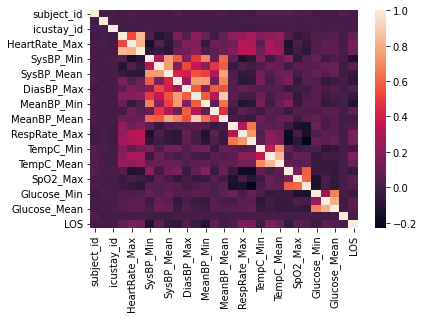

In [ ]:
sns.heatmap(train.corr())

### Binning LOS (New)
Will Create deciles of LOS for visualization purposes


In [ ]:
#Create deciles of LOS for visualization purposes
q = 10
train['LOS_deciles'] = pd.qcut(train['LOS'], q)

In [ ]:
#Create quartiles LOS bins for visualization purposes
#Quartiles worked out quite nicely as I have those who stayed about 1 day, those who stayed 1-2 days, 2-4 days, and 4 or more days
q = 4
labels_quartiles = ['<1 Day', '1-2 Days', '2-4 days', '4+ days']
train['LOS_qtiles'] = pd.qcut(train['LOS'], q, labels=labels_quartiles)

Trends seem to be very similar for male and female. Generally, the shortest stays belong to those who arrive in the hours of 20:00-24:00. 

### Create age column (Nothing new)

As explained in the last assignment:
"Dates of birth for patients aged over 89 were shifted to obscure their true age and comply with HIPAA regulations: these patients appear in the database with ages of over 300 years."
 
Below I first calculate ages for all of the patients at time of admission and then change all patients with fake ages to aged 93 (arbitrary).

In [ ]:
#Get the month of the datetime by slicing and turning to int

month = train['DOB'].str[5:7].astype(int)
month_tst = test['DOB'].str[5:7].astype(int)

#In order to get number of days in addition to the year I will need to subtract one month so it's not
#double counted and multiply by 30 (average number of days in a month is 30.437)

month = (month - 1)*30
month_tst = (month_tst - 1)*30

#I now have number of days in addition to the year in months (roughly, this isn't exact of course given leap years and varying month lengths).
#Need to add in the days now

monthdays = train['DOB'].str[8:10].astype(int)
extradays = month + monthdays.astype(int)

monthdays_tst = test['DOB'].str[8:10].astype(int)
extradays_tst = month_tst + monthdays_tst.astype(int)

#Now get total number of days for the given year and sum them all

year = train['DOB'].str[:4].astype(int)
year_tst = test['DOB'].str[:4].astype(int)

yeardays = year * 365
yeardays_tst = year_tst * 365


#Now add all together (add diff because it's given as a negative) to get a workable DOB column. 
#I realize this isn't exact but should be able to differentiate people enough for the model

diff = train['Diff']
diff_tst = test['Diff']

train['DOB'] = (yeardays + extradays + diff) / 365
test['DOB'] = (yeardays_tst + extradays_tst + diff_tst) / 365


traindob = (yeardays + extradays + diff) / 365
testdob = ((yeardays_tst + extradays_tst + diff_tst) / 365)

#Dividing the test column above by 365 gives me what look to be birth years and days, 
#but upon closer inspection there was someone born in 1709 for example.

testdob.describe()

count = 0
for i in testdob :
    if i < 1800 :
        count = count + 1

print('There are',count,'people over the age of 89 in the test dataset')

#train[train['DOB'] < 1900]

There are 270 people over the age of 89 in the test dataset


Now if I do the same for admit time and then subtract my DOB, I should have an age to work with

In [ ]:
month = train['ADMITTIME'].str[5:7].astype(int)
month_tst = test['ADMITTIME'].str[5:7].astype(int)

#In order to get number of days in addition to the year I will need to subtract one month so it's not
#double counted and multiply by 30 (average number of days in a month is 30.437)

month = (month - 1)*30
month_tst = (month_tst - 1)*30

#I now have number of days in addition to the year in months (roughly, this isn't exact of course given leap years and varying month lengths).
#Need to add in the days now

monthdays = train['ADMITTIME'].str[8:10].astype(int)
extradays = month + monthdays.astype(int)

monthdays_tst = test['ADMITTIME'].str[8:10].astype(int)
extradays_tst = month_tst + monthdays_tst.astype(int)

#Now get total number of days for the given year and sum them all

year = train['ADMITTIME'].str[:4].astype(int)
year_tst = test['ADMITTIME'].str[:4].astype(int)

yeardays = year * 365.242
yeardays_tst = year_tst * 365.242


#Now add all together (add diff because it's given as a negative) to get a workable ADMITTIME column. 
#I realize this isn't exact but should be able to differentiate people enough for the model

diff = train['Diff']
diff_tst = test['Diff']

train['ADMITDAY'] = (yeardays + extradays + diff) / 365.242
test['ADMITDAY'] = (yeardays_tst + extradays_tst + diff_tst) / 365.242


trainADMITTIME = (yeardays + extradays + diff) / 365.242
testADMITTIME = ((yeardays_tst + extradays_tst + diff_tst) / 365.242)

#Dividing the test column above by 365.242 gives me what look to be birth years and days, 
#but upon closer inspection there was someone born in 1709 for example, which I later discovered is due to 
#HIPAA regulation saying that people over age 89 must be shown as over age 300

print(testADMITTIME.describe())

#My admittime seems sensible, with data from 2007-2012

count    5221.000000
mean     2010.309503
std         1.417956
min      2007.898423
25%      2008.999774
50%      2010.271886
75%      2011.548567
max      2012.775308
dtype: float64


In [ ]:
testADMITTIME.describe()

count    5221.000000
mean     2010.309503
std         1.417956
min      2007.898423
25%      2008.999774
50%      2010.271886
75%      2011.548567
max      2012.775308
dtype: float64

In [ ]:
train['AGE'] = train['ADMITDAY'] - train['DOB']
test['AGE'] = test['ADMITDAY'] - test['DOB']

The following looks ok! I just need to adjust the odd outlier of those over 89 being classified as over 300 years old due to the HIPAA regulation.

In [ ]:
train['AGE'].describe()

count    20885.000000
mean        75.455786
std         55.673833
min         15.146120
25%         53.391010
50%         65.751783
75%         78.115720
max        310.286737
Name: AGE, dtype: float64

Given age above 90 is likely very important, I should classify these people as such and eliminate the age of 300.

In [ ]:
#Now I will impute the data to give those people a uniformly distributed random age between 90 and 100. 
#93 didn't work very well in the last exercise
train.loc[train['AGE'] > 90, 'AGE'] = np.random.uniform(90,100)
test.loc[test['AGE'] > 90, 'AGE'] = np.random.uniform(90,100)

In [ ]:
#Now I drop date columns I don't need
train = train.drop(['DOB', 'Diff', 'ADMITDAY'], axis=1)
test = test.drop(['DOB', 'Diff', 'ADMITDAY'], axis=1)

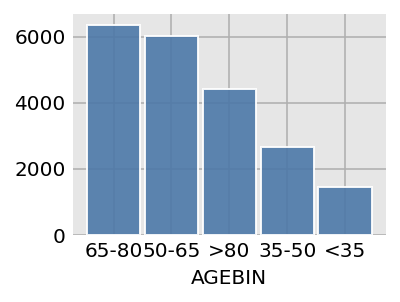

In [ ]:
#Create age bins
bins = [0, 35, 50, 65, 80, 305]
labels = ['<35', '35-50', '50-65','65-80', '>80']
train['AGEBIN'] = pd.cut(train['AGE'], bins, labels=labels)
test['AGEBIN'] = pd.cut(test['AGE'], bins, labels=labels)

dxp.count(val='AGEBIN', data=train)

### Create Admission Hour and Bins (New)

In [ ]:
#Get admit time of day, as this might be useful
train['ADMITTIME'] = train['ADMITTIME'].str[11:13].astype(int)
test['ADMITTIME'] = test['ADMITTIME'].str[11:13].astype(int)

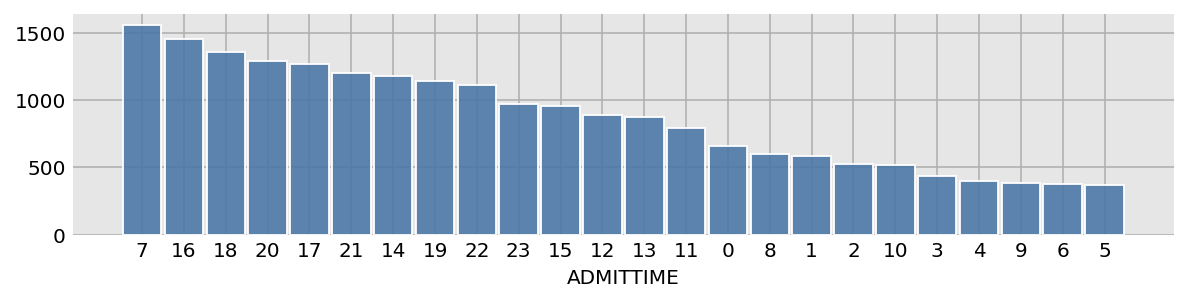

In [ ]:
dxp.count(val='ADMITTIME', data=train)

In [ ]:
#Create buckets using cut method for visualization purpose
bins = [-1, 4, 8, 12, 16, 20, 24]
labels = ['After Midnight', 'Early Morning', 'Late Morning', 'Afternoon', 'Evening', 'Pre-Midnight']
train['ADMITBINS'] = pd.cut(train['ADMITTIME'], bins, labels=labels)
test['ADMITBINS'] = pd.cut(test['ADMITTIME'], bins, labels=labels)

Grouping into bins changes the visualization - we can now ssee that evening is the most common time for admission

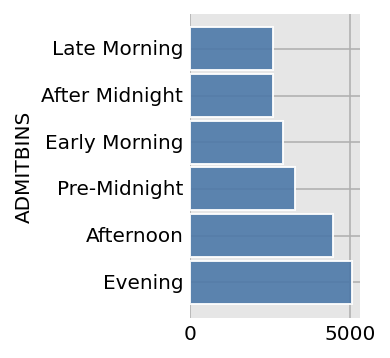

In [ ]:
#Visualize
dxp.count(val='ADMITBINS', data=train, orientation='h')

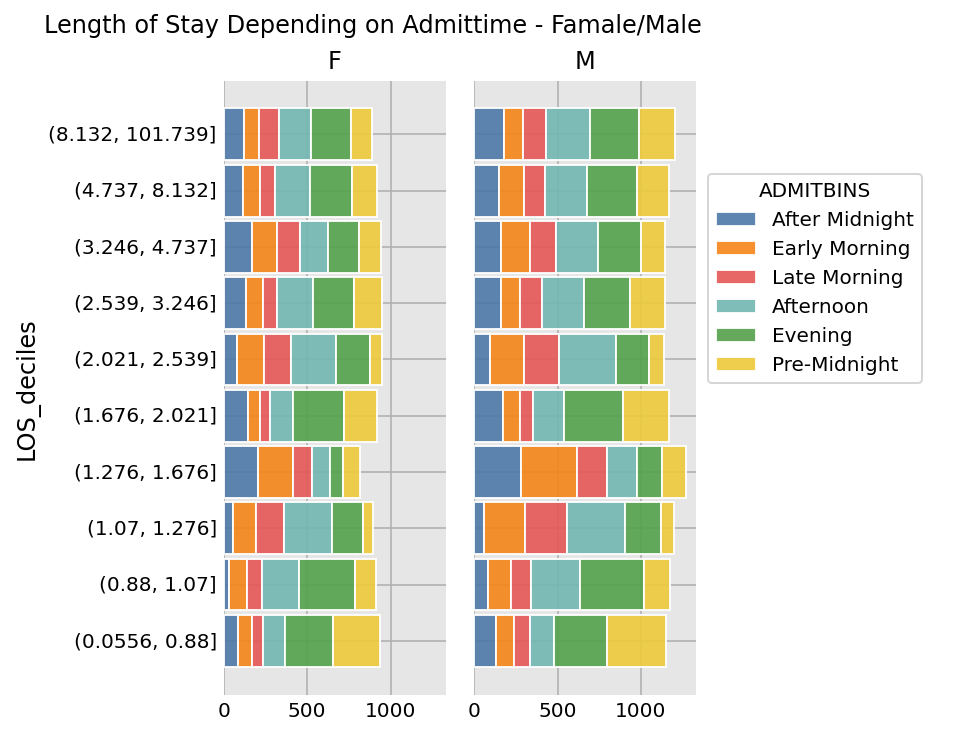

In [ ]:
dxp.count(val='LOS_deciles', data=train, split='ADMITBINS', 
          orientation='h', stacked=True, col='GENDER', title="Length of Stay Depending on Admittime - Famale/Male")

It seems that those that arrived at the hospital in the morning, particlarly 7 or 8 am, were likeliest to survive. But it's not a wide margin.

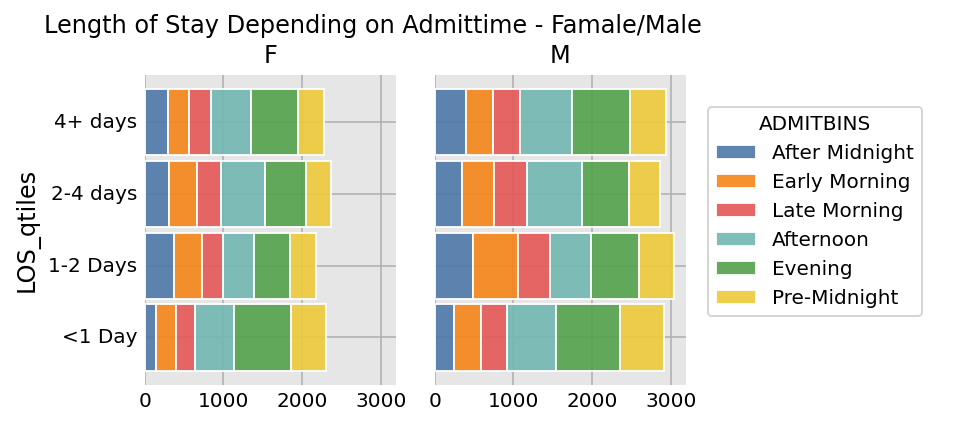

In [ ]:
#Example
dxp.count(val='LOS_qtiles', data=train, split='ADMITBINS', 
          orientation='h', stacked=True, col='GENDER', title="Length of Stay Depending on Admittime - Famale/Male")

### Create admission month and bins

In [ ]:
train['ADMITMONTH'] = raw_train['DOB'].str[5:7].astype(int)
test['ADMITMONTH'] = raw_test['DOB'].str[5:7].astype(int)

In [ ]:
#Turn December into 0 for binning purposes so it can be inlcuded with January and February

In [ ]:
train['ADMITMONTH'] = train['ADMITMONTH'].replace(12,0)
test['ADMITMONTH'] = test['ADMITMONTH'].replace(12,0)

In [ ]:
#Create buckets using cut method for visualization purpose
bins = [-1, 2, 5, 8, 11]
labels = ['Winter', 'Spring', 'Summer','Autumn']
train['SEASON'] = pd.cut(train['ADMITMONTH'], bins, labels=labels)
test['SEASON'] = pd.cut(test['ADMITMONTH'], bins, labels=labels)

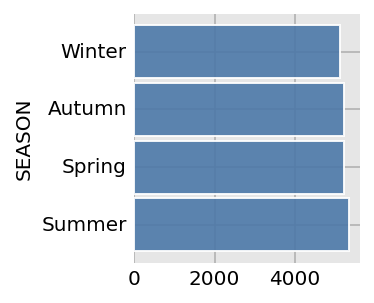

In [ ]:
dxp.count(val='SEASON', data=train, orientation='h')

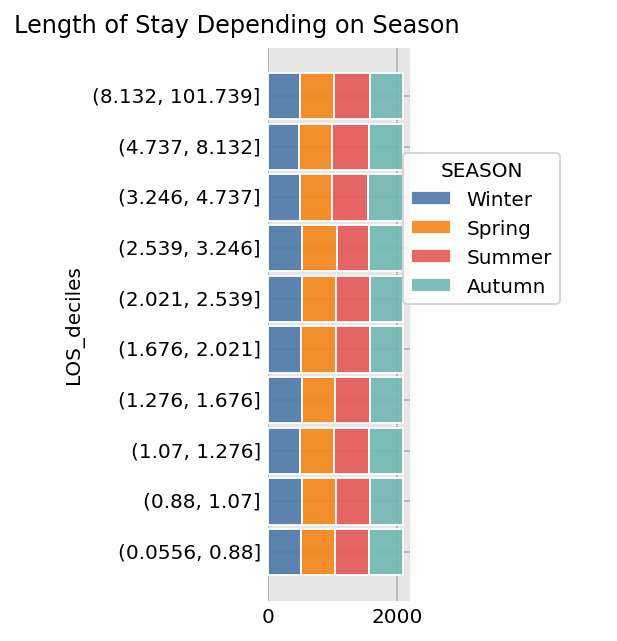

In [ ]:
dxp.count(val='LOS_deciles', data=train, split='SEASON', 
          orientation='h', stacked=True, title="Length of Stay Depending on Season")

This also looks pretty even across the board

## Comorbidities data

This data set contains a lot of useful information, but is not easy to work with given the large volume of text data and codes. I analyze the comorbidities but decide to add the counts of comorbidities back into my training set for the sake of computation time. It could have been possible to add the sparse matrix of comorbidities back in.

Based on some [research](https://opendata.stackexchange.com/questions/9335/what-is-the-exactly-relationship-between-the-diagnoses-priority-and-the-treatmen):

> "The ICD codes are used for billing and do not impact treatment. This is an important point to understand when carrying out research using databases such as MIMIC."

> "My understanding, based on conversations with nursing staff at the hospital, is that the first number in the sequence (seq_num = 1) generally indicates the primary diagnosis, which is often the reason for admission. The order of later codes in the sequence (seq_num = 2+) has less significance and indicates additional diagnoses relevant for billing."

### ID Columns

Unfortunately there is no ICU ID, so I don't have a unique ID for each observation that I can neatly fit into the original dataframe.

Just to be safe, I'll create a 'Uniquer_ID' that is a combination of Subject_ID and HADM_ID. I used division in case two ids added up to the same number

In [ ]:
#This may not be necessary but might be slightly more efficient
train['uniquer_id'] = train['hadm_id'] / train['subject_id']
test['uniquer_id'] = test['hadm_id'] / test['subject_id']
comorbs['uniquer_id'] = comorbs['hadm_id'] / comorbs['subject_id']

# Merge comorbidities and reasons so I can evaluate text later
cmbs = pd.merge(comorbs, reasons, on=['icd9_code',  'icd9_code'], how='left')

Check for subject_ids not in test or training set

In [ ]:
subjectid_all = pd.concat([test['subject_id'], train['subject_id']], axis = 0)

#Out of curiosity, now that I have all subject_ids, I can check for duplicate 
#subject_ids across train and test

print('There are', test['subject_id'].nunique() + train['subject_id'].nunique(), 
      'unique subject IDs when summing the unique training IDs and the unique test IDs, out of a possible', 
       test['subject_id'].count() + train['subject_id'].count())

print('There are', subjectid_all.nunique(), 
      'unique subject IDs from the combined train and test, out of a possible', 
       subjectid_all.count())

There are 21164 unique subject IDs when summing the unique training IDs and the unique test IDs, out of a possible 26106
There are 19590 unique subject IDs from the combined train and test, out of a possible 26106


Above indicates there are subject_ids in the test set that are also in the training set. Something to keep in mind

In [ ]:
subjectid_all = subjectid_all.to_frame().reset_index()
subjectid_all = subjectid_all.drop(['index'], axis=1)

extra_subjectids = cmbs['subject_id']
extra_subjectids = extra_subjectids.to_frame()

for i in subjectid_all['subject_id']:
  if i not in extra_subjectids['subject_id']:
   print(i)

There are no subject_ids in the extra data set that are not in the training or testing set. I was hoping to be able to drop some of the observations.

#### Add total comorbidities for each stay

SEQ Number seems important (more comorbidities the worse), so I'll get the max sequence number for each visit (subject_id+hadm_id)

In [ ]:
cmbs['visit_cmbs'] = cmbs.groupby(['subject_id','hadm_id'])['seq_num'].transform('count')
cm_ids = cmbs.filter(['uniquer_id', 'visit_cmbs'], axis=1) #temporary dataframe
#Create temporary df t9 for merging with training set
t8 = train.copy()
t8 = pd.merge(t8, cm_ids, left_on='uniquer_id', right_on='uniquer_id', how='inner')
t8 = t8.drop_duplicates(subset=None, keep='first', inplace=False)
t8 = t8.reset_index(inplace=False)
train['visit_cmbs'] = t8['visit_cmbs']

#Test set
t9 = test.copy()
t9 = pd.merge(t9, cm_ids, left_on='uniquer_id', right_on='uniquer_id', how='inner')
t9 = t9.drop_duplicates(subset=None, keep='first', inplace=False)
t9 = t9.reset_index(inplace=False)
test['visit_cmbs'] = t9['visit_cmbs']

In [ ]:
#Put comorbidities into bins
q1 = 5
train['comorbs_bins'] = pd.qcut(train['visit_cmbs'], q1)
test['comorbs_bins'] = pd.qcut(test['visit_cmbs'], q1)

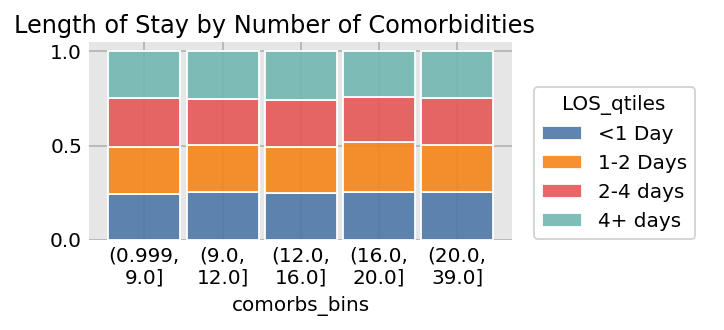

In [ ]:
#Visualize comorbidities
dxp.count('comorbs_bins', data=train, split='LOS_qtiles', 
          normalize=['comorbs_bins'], 
          orientation='v', stacked=True, title='Length of Stay by Number of Comorbidities')

Number of comorbidities is not an obvious indicator of LOS. In fact it is remarkably consistent!

Here I will add in a piece of code from our repository of shared notebooks in the last example. I thought this one was a well done way to calculate some extra information on LOS combined with the extra dataset.

Note I adapt the code for LOS instead of Hospital_Expire_Flag, as we are unable to use hospital expire flag here.

### LOS_proxy
This is adapted from Philine's notebook posted in the student model solutions. After dozens of attempts with combinations of variables and transformations, this proved to be the key difference maker 

In [ ]:
comorbidity = comorbs
comorbidity = comorbidity.dropna()
comorbidity = pd.merge(left=comorbidity,
                       right=train[['subject_id', 'hadm_id', 'LOS']],
                       how='left',
                       on=['subject_id', 'hadm_id'])
los_proxy = comorbidity.groupby('icd9_code')['LOS'].mean().reset_index()
los_proxy = los_proxy.rename(columns={'LOS': 'los_proxy', 'icd9_code': 'ICD9_diagnosis'})
los_proxy.head()
los_proxy = comorbidity.groupby('icd9_code')['LOS'].mean().reset_index()
los_proxy = los_proxy.rename(columns={'LOS': 'los_proxy', 'icd9_code': 'ICD9_diagnosis'})
los_proxy.head()
comorbidity['los_proxy'] = comorbidity['LOS'].groupby(comorbidity['icd9_code']).transform('mean')
comorbidity['max_los'] = comorbidity['los_proxy'].groupby(comorbidity['subject_id']).transform('max')
comorbidity['mean_los'] = comorbidity['los_proxy'].groupby(comorbidity['subject_id']).transform('mean')
comorbidity.head(10)
comorbidity = comorbidity.drop_duplicates(subset=['subject_id', 'hadm_id'])
train = pd.merge(left=train, 
                right=los_proxy[['ICD9_diagnosis', 'los_proxy']],
                how='left', on='ICD9_diagnosis')

test = pd.merge(left=test, 
                right=los_proxy[['ICD9_diagnosis', 'los_proxy']],
                how='left', on='ICD9_diagnosis')

train = pd.merge(left=train, 
                right=comorbidity[['subject_id', 'hadm_id', 'max_los', 'mean_los']],
                how='left', on=['subject_id', 'hadm_id'])

test = pd.merge(left=test, 
                right=comorbidity[['subject_id', 'hadm_id', 'max_los', 'mean_los']],
                how='left', on=['subject_id', 'hadm_id'])

print(train.shape)
print(test.shape)

(20885, 51)
(5221, 48)


## Continous Variables

### Health markers
I will consider consolidating the health markers that are broken down into mean, min, and max.
To start, I think a range of values column will be useful. 


#### Create new features

In [ ]:
#Add range of values to inspect

train['HeartRate_Range'] = train['HeartRate_Max'].subtract(train['HeartRate_Min'])
train['SysBP_Range'] = train['SysBP_Max'].subtract(train['SysBP_Min'])
train['DiasBP_Range'] = train['DiasBP_Max'].subtract(train['DiasBP_Min'])
train['MeanBP_Range'] = train['MeanBP_Max'].subtract(train['MeanBP_Min'])
train['RespRate_Range'] = train['RespRate_Max'].subtract(train['RespRate_Min'])
train['TempC_Range']= train['TempC_Max'].subtract(train['TempC_Min'])
train['SpO2_Range'] = train['SpO2_Max'].subtract(train['SpO2_Min'])
train['Glucose_Range'] = train['Glucose_Max'].subtract(train['Glucose_Min'])

#Add pulse data
train['PulsePressure_Min'] = train['SysBP_Min'].subtract(train['DiasBP_Min'])
train['PulsePressure_Mean'] = train['SysBP_Mean'].subtract(train['DiasBP_Mean'])
train['PulsePressure_Max'] = train['SysBP_Max'].subtract(train['DiasBP_Min'])
train['PulsePressure_Range'] = train['PulsePressure_Max'].subtract(train['PulsePressure_Min'])


#FOR TEST SET
test['HeartRate_Range'] = test['HeartRate_Max'].subtract(test['HeartRate_Min'])
test['SysBP_Range'] = test['SysBP_Max'].subtract(test['SysBP_Min'])
test['DiasBP_Range'] = test['DiasBP_Max'].subtract(test['DiasBP_Min'])
test['MeanBP_Range'] = test['MeanBP_Max'].subtract(test['MeanBP_Min'])
test['RespRate_Range'] = test['RespRate_Max'].subtract(test['RespRate_Min'])
test['TempC_Range']= test['TempC_Max'].subtract(test['TempC_Min'])
test['SpO2_Range'] = test['SpO2_Max'].subtract(test['SpO2_Min'])
test['Glucose_Range'] = test['Glucose_Max'].subtract(test['Glucose_Min'])
test['PulsePressure_Min'] = test['SysBP_Min'].subtract(test['DiasBP_Min'])
test['PulsePressure_Mean'] = test['SysBP_Mean'].subtract(test['DiasBP_Mean'])
test['PulsePressure_Max'] = test['SysBP_Max'].subtract(test['DiasBP_Min'])
test['PulsePressure_Range'] = test['PulsePressure_Max'].subtract(test['PulsePressure_Min'])

### Visual Inspections
I will now visually inspect every continuous variable and compare those who died versus those who did not


In [ ]:
#Prepare for dexplot
vis = train.select_dtypes([np.number])
vis = clean_dataset(vis)
vis['LOS_qtiles'] = pd.qcut(vis['LOS'], q, labels=labels_quartiles)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Heart Rate

It could be interesting to create a new variable that shows heart rate max as a function of age, as the max heart rate depends on your age. Then see what the heart_rate_max is relative to the persons age

In [ ]:
train['HeartRateMax_Age'] = (train['HeartRate_Max'] / (220 - train['AGE']) )
test['HeartRateMax_Age'] = (test['HeartRate_Max'] / (220 - test['AGE']) )

vis['HeartRateMax_Age'] = (vis['HeartRate_Min'] / (220 - vis['AGE']) )

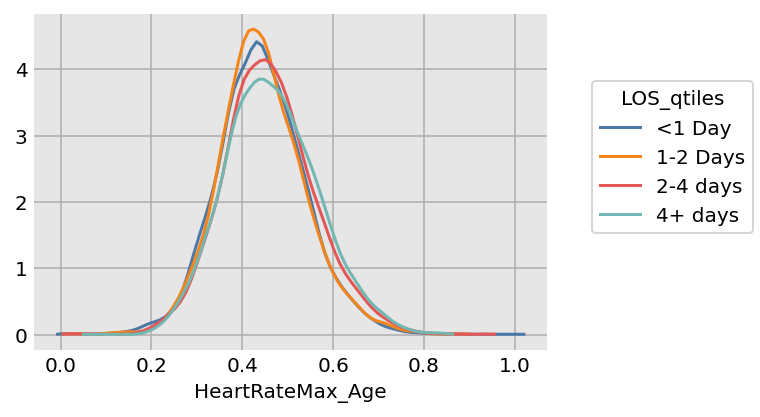

In [ ]:
dxp.kde(x='HeartRateMax_Age', data=vis, split='LOS_qtiles')

Interesting progression for those who had stays longer than 4 days

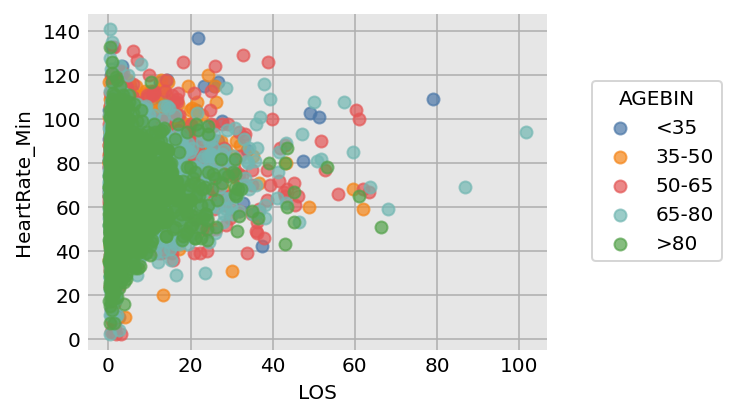

In [ ]:
dxp.scatter(x='LOS', y='HeartRate_Min', data=train, 
            split='AGEBIN', wrap=2)

There aren't a lot of observations with heart_rate below 20, but those that are seem mainly to be staying less than 2 days (perhaps because they die)

In [ ]:
#train = train.drop(columns=['HeartRate_Max'])
#test = test.drop(columns=['HeartRate_Max'])

Glucose

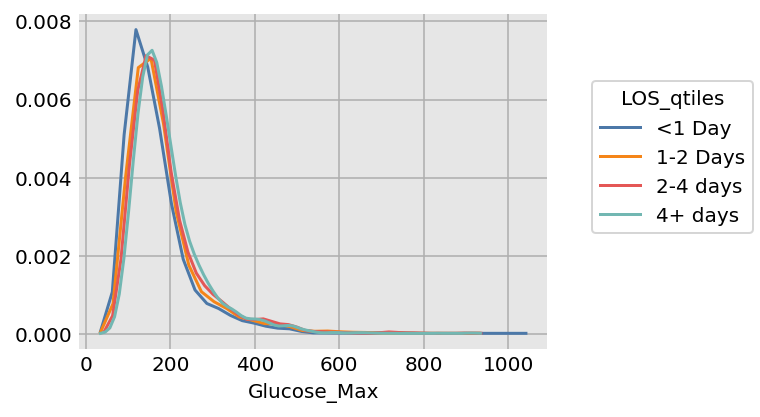

In [ ]:
dxp.kde(x='Glucose_Max', data=vis, split='LOS_qtiles')

Glucose does not seem to be very important, but there are slight variations that could be useful. Will keep all.

Respiration Rate



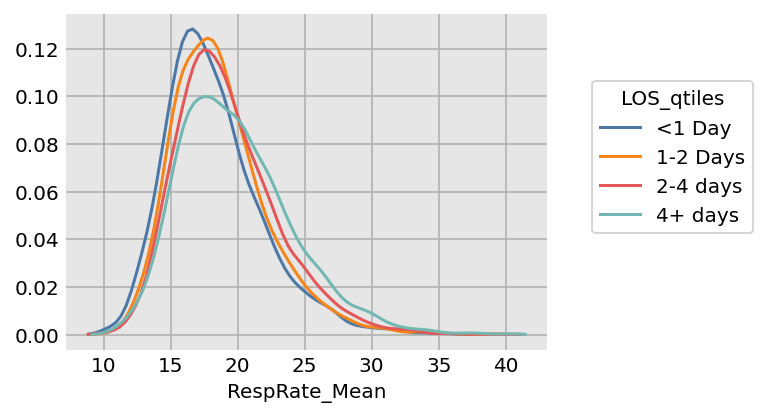

In [ ]:
dxp.kde(x='RespRate_Mean', data=vis, split='LOS_qtiles')

Respiration rate is a bit lower for those with shorter stays

SpO2

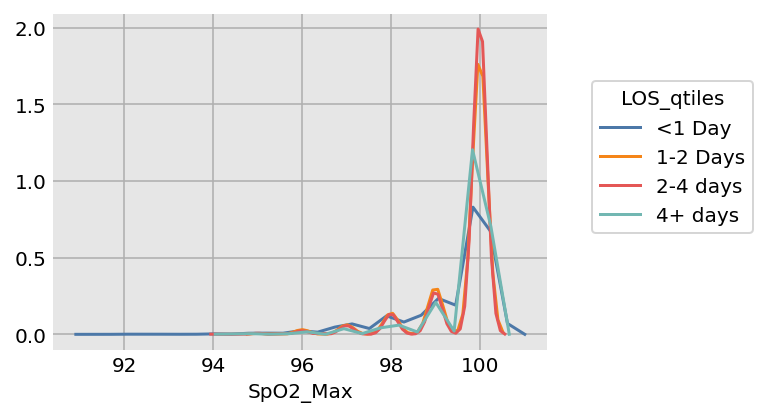

In [ ]:
dxp.kde(x='SpO2_Max', data=vis, split='LOS_qtiles')

Oxygen levels follow similar pattern for all LOS bins

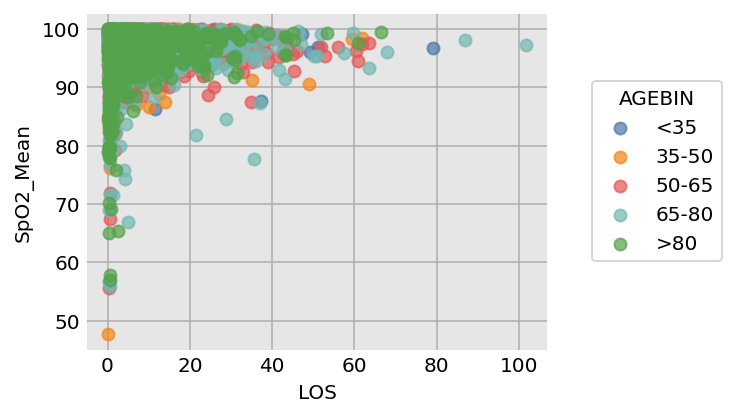

In [ ]:
dxp.scatter(x='LOS', y='SpO2_Mean', data=train, 
            split='AGEBIN', wrap=2)

Upon further review, having a mean SpO2 below 90 is indeed not a good sign at all and a likely predictor of death, so I can see many of those people who stayed less than one day died relatively soon.

TempC

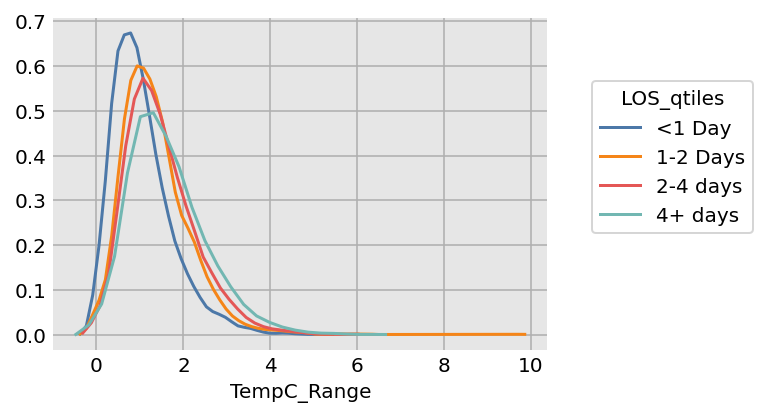

In [ ]:
dxp.kde(x='TempC_Range', data=vis, split='LOS_qtiles')

Higher temperature range the longer the stay. Useful!

Blood Pressure


I also recognize that there are three different types of blood pressure. Based on this website: https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/expert-answers/pulse-pressure/faq-20058189, I decided to subtract the two to get an indicator of heart health via pulse pressure

This source indicates: ["Most studies show a greater risk of stroke and heart disease related to higher systolic pressures compared with elevated diastolic pressures."](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiAg43w6Iv2AhV18rsIHYvTCRMQFnoECAYQAw&url=https%3A%2F%2Fwww.health.harvard.edu%2Fstaying-healthy%2Fwhich-blood-pressure-number-is-important&usg=AOvVaw2g5s2V6Pk8JG67dI7I13rI)

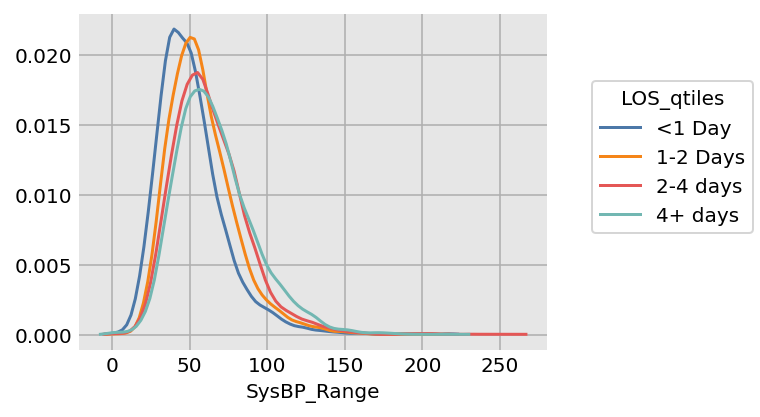

In [ ]:
dxp.kde(x='SysBP_Range', data=vis, split='LOS_qtiles')

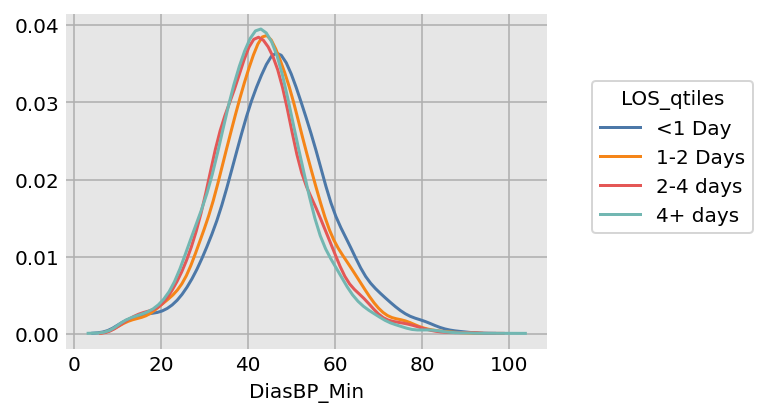

In [ ]:
dxp.kde(x='DiasBP_Min', data=vis, split='LOS_qtiles')

Larger for those who stay less than a day

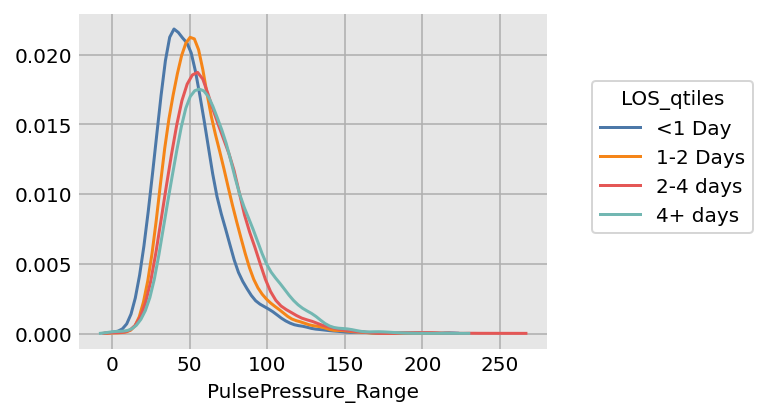

In [ ]:
dxp.kde(x='PulsePressure_Range', data=vis, split='LOS_qtiles')

Larger for those who stay more than 4 days

Interesting visualization I can do across variables if I want to inspect further, particularly for outliers

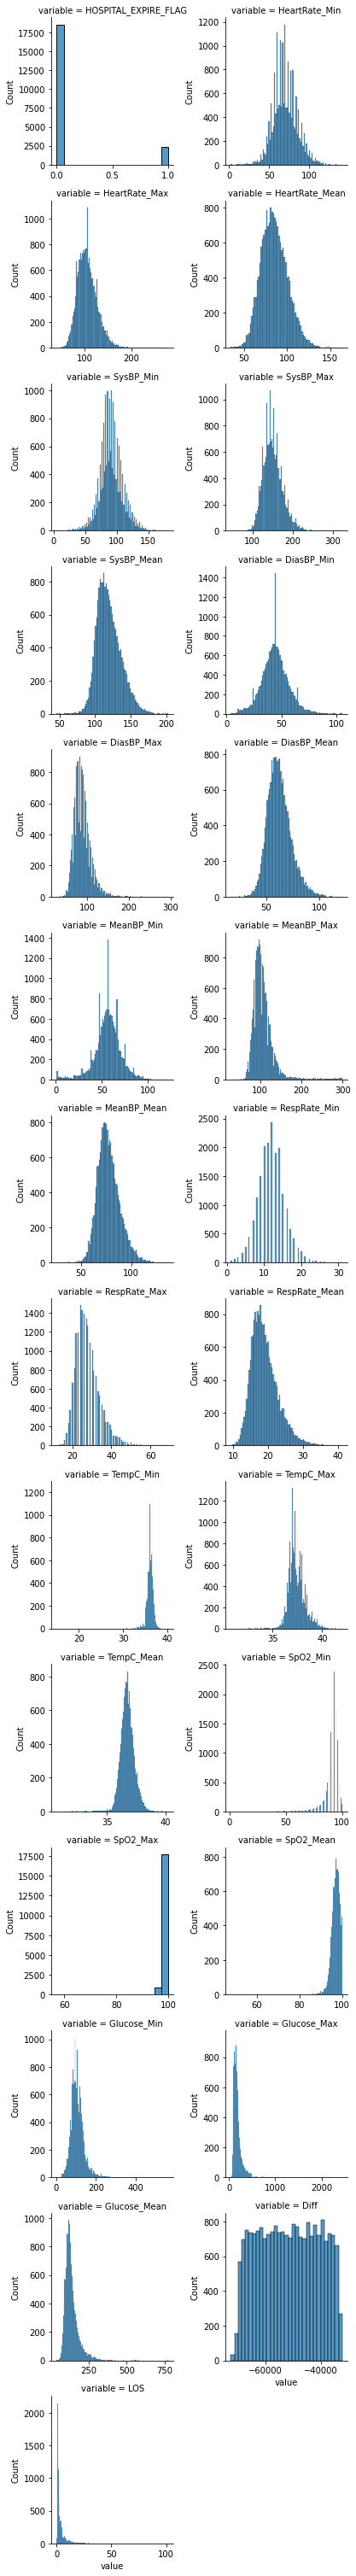

In [ ]:
trainnums = raw_train.select_dtypes([np.number])
trainnums = trainnums.drop(columns=['subject_id','hadm_id', 'icustay_id'])
dens_data = [f for f in trainnums.columns]
f = pd.melt(trainnums, value_vars=dens_data)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.histplot, "value")

Most of the features are approximately normally distributed and will not require further transformation.



#### Look at scatter plots

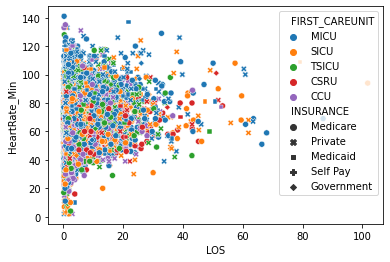

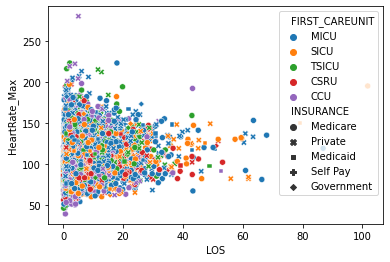

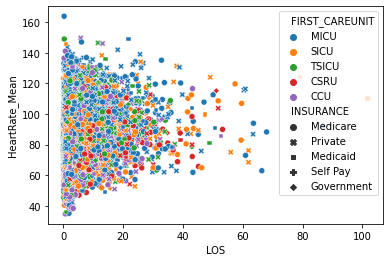

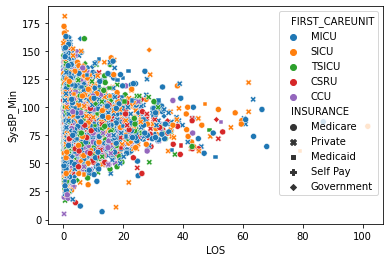

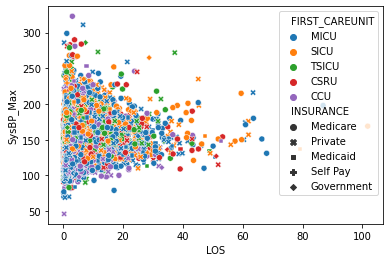

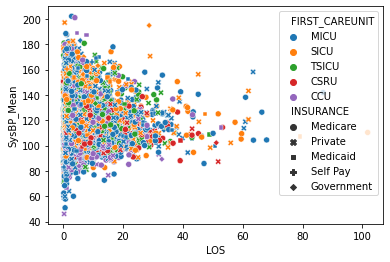

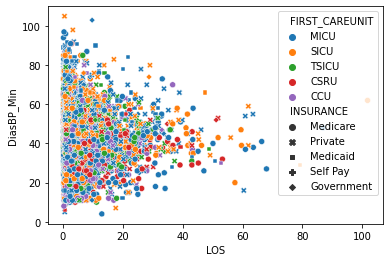

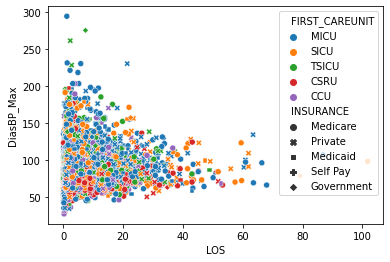

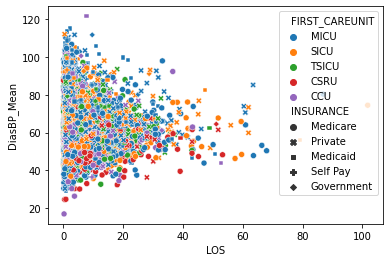

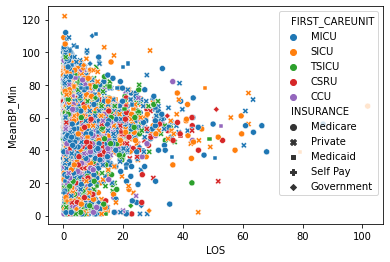

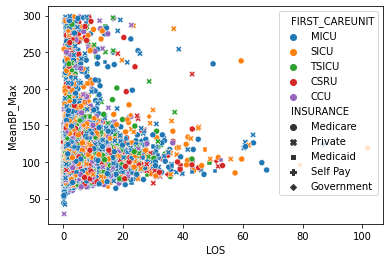

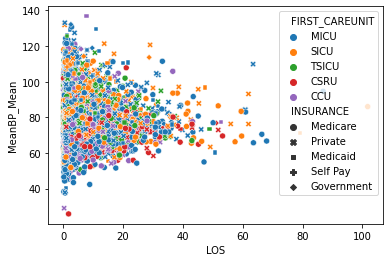

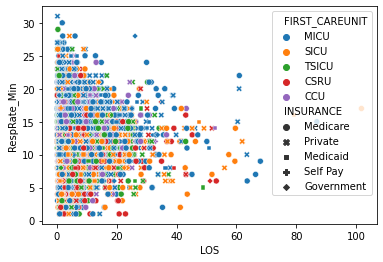

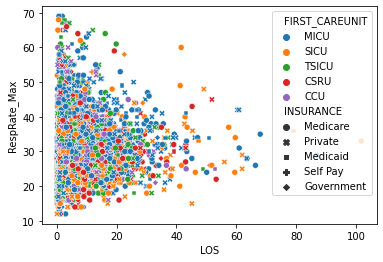

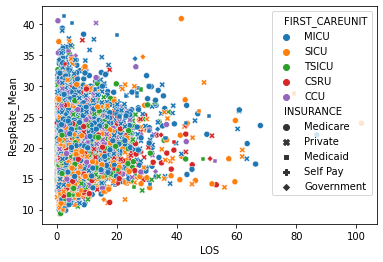

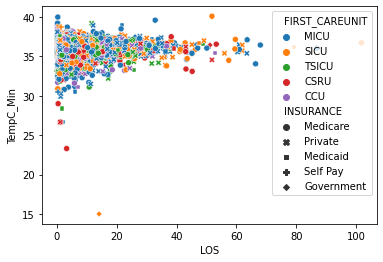

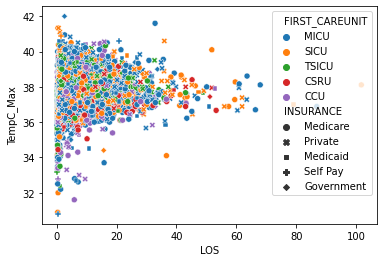

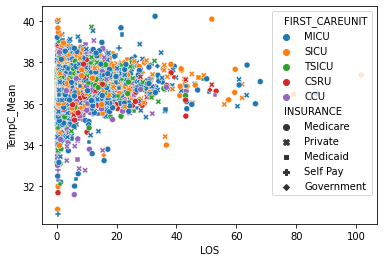

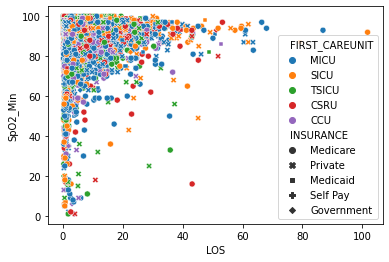

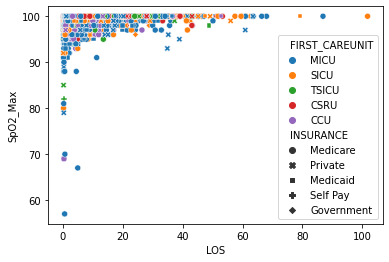

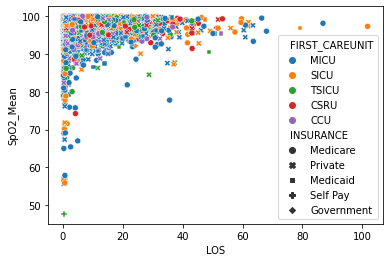

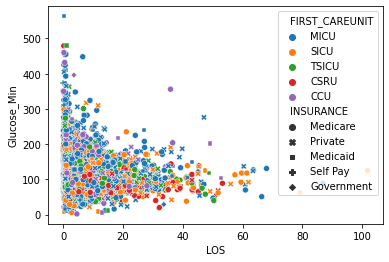

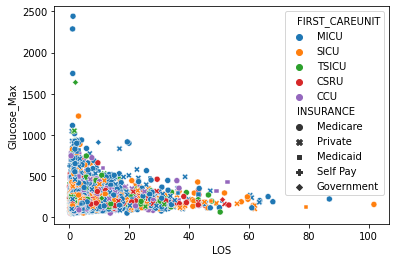

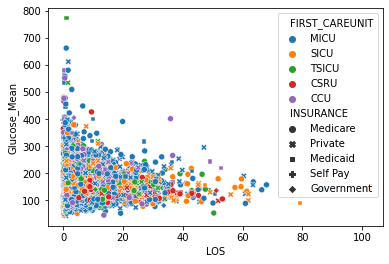

In [ ]:
#First inspect scatter plots to view outliers
nums = raw_train.select_dtypes(exclude=['object', 'category'])
nums = nums.drop(axis=1, columns=['icustay_id', 'subject_id', 'hadm_id', 'Diff'])
nums['qtiles'] = train['LOS_qtiles']
for col in nums.columns[1:25]:
    sns.scatterplot(nums.LOS, nums[col], hue=train['FIRST_CAREUNIT'], style=train['INSURANCE'])
    plt.show()

### Outliers

There is a possibility that error outliers exist, having read [this paper ](https://arxiv.org/pdf/1907.08322v2.pdf) which predicted LOS from the same data. It indicates that there are outliers that are not clinically feasible and should be removed. It's possible this is in my data as well, so I will explore imputing them.

I tried Winsorizing [from scipy stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html).  It did not help.


In [ ]:
# from scipy.stats.mstats import winsorize
# glucose = winsorize(train['Glucose_Max'],  limits=[0.1,1500])

For example, max glucose has a max of 2440 which is massive relative to the mean.

I have read that extremely "high blood sugar levels (for example, 1000 or more mg/dL) can cause diabetic ketoacidosis, which can lead to loss of consciousness and is life-threatening." So the short stay caused by that was probably a death.

In [ ]:
train['Glucose_Max'].describe()

count    20632.000000
mean       182.129604
std         92.665603
min         42.000000
25%        126.000000
50%        161.000000
75%        206.000000
max       2440.000000
Name: Glucose_Max, dtype: float64

In [ ]:
High_Glucose = train[train.Glucose_Max > 1000]

In [ ]:
train["LOS"].describe()

count    20885.000000
mean         3.701046
std          5.175721
min          0.056600
25%          1.165400
50%          2.020800
75%          3.915800
max        101.739000
Name: LOS, dtype: float64

In [ ]:
High_Glucose['LOS'].describe()

count    10.000000
mean      1.477320
std       0.667129
min       0.787800
25%       1.074100
50%       1.168550
75%       1.697550
max       3.041700
Name: LOS, dtype: float64

It seems that those 10 people with max_glucose levels above 1000 have shorter stays, perhaps because they died.



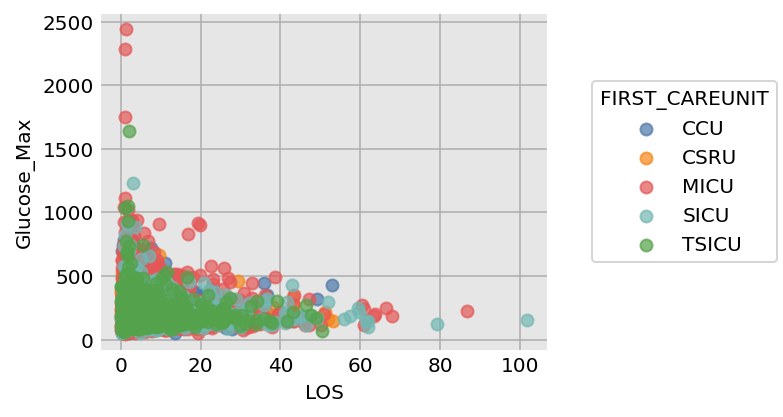

In [ ]:
dxp.scatter(x='LOS', y='Glucose_Max', data=train, split='FIRST_CAREUNIT')

This is interesting. It indicates that those with extremely high glucose levels are probably likely to die and therefore have very short stays. I need to figure out what is causing the outliers above 60.

I looked into using Isolation Forest to detect and potentially remove outliers but did not end up utilizing it.

In [ ]:
# from sklearn.ensemble import IsolationForest
# iso = IsolationForest(contamination=0.1)
# yhat = iso.fit_predict(Xtr)
# mask = yhat != -1

#train_outlier, y_outlier = Xtr[mask, :], y_train[mask]

## Categoricals

New additions from last submission are insurance inspection is actually quite interesting, self-pay insurance tends to stay less which makes sense. I also further inspected diagnoses and noticed a few that are correlated with higher length of stay.

### Visual Inspections

Admission Type

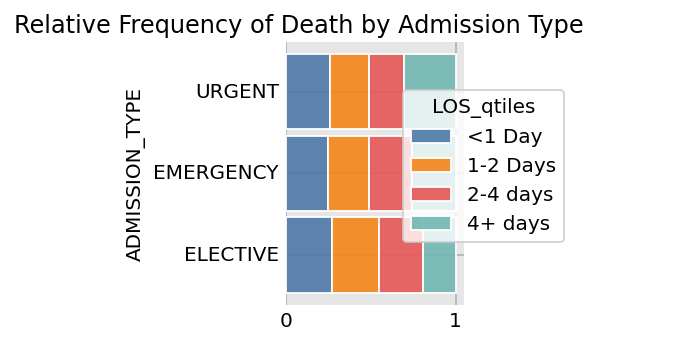

In [ ]:
dxp.count('ADMISSION_TYPE', data=train, split='LOS_qtiles', 
          normalize=['ADMISSION_TYPE'], split_order='asc',
          orientation='h', stacked=True, title='Relative Frequency of Death by Admission Type')

Notice a trend in that urgent tends to have longer stays

As indicated in the tutor copy:

> For ordinal variables, assuming that there is always a progression from first to last, it makes sense to use directly the integer value of the ordinal, and compute Euclidean distance (after rescaling). With this assumption, we assume an observation with rank #1 is two times closer to an observation with rank #2 (it's one rank away), than an observation that has rank #4 (it's two ranks away).

So I will convert Admission_Type into a progression

In [ ]:
#Replace admission type with scale of 1-7 on degree of urgency
train['ADMISSION_SEVERITY'] = train['ADMISSION_TYPE'].replace('ELECTIVE', 1)
train['ADMISSION_SEVERITY'] = train['ADMISSION_SEVERITY'].replace('URGENT', 3)
train['ADMISSION_SEVERITY'] = train['ADMISSION_SEVERITY'].replace('EMERGENCY', 7)

test['ADMISSION_SEVERITY'] = test['ADMISSION_TYPE'].replace('ELECTIVE', 1)
test['ADMISSION_SEVERITY'] = test['ADMISSION_SEVERITY'].replace('URGENT', 3)
test['ADMISSION_SEVERITY'] = test['ADMISSION_SEVERITY'].replace('EMERGENCY', 7)

First Care Unit

First Care Unit labels correspond to:

* SICU - Surgical Intensive Care Unit
* CCU - Coronary Care Unit
* MICU - Medical Intensive Care Unit
* CSRU - Cardiac Surgery Recovery Unit
* TSICU - Trauma Surgical Intensive Care Unit


I imagine some of these have higher death rates than others. [One study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4711206/) found that "Individual average mortality was 7% in MICU, 8.5% in SICU, and 8.2% in CCU." Not a huge difference, but worth noting that MICU is the lowest in that study. 

When looking at the data among those that died, it seems MICU had the most mortalities. But that could likely just be because MICU


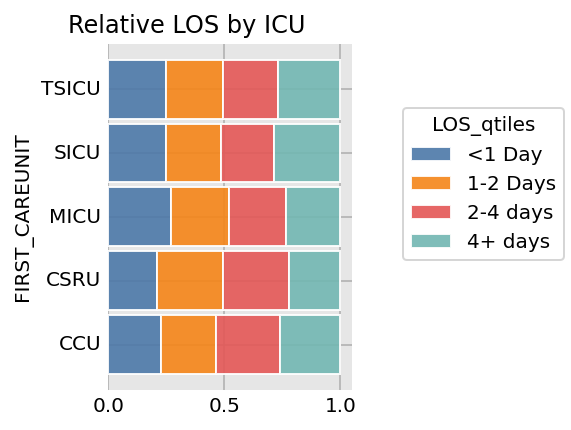

In [ ]:
dxp.count('FIRST_CAREUNIT', data=train, split='LOS_qtiles', 
          normalize=['FIRST_CAREUNIT'], 
          orientation='h', stacked=True, title='Relative LOS by ICU')

The CSRU seems to have the shortest stay (which makes sense considering it is a surgery recovery unit), but the others are fairly similar.

I could create a dummy for CSRU or let encoding take care of that.

In [ ]:
#Did not end up using these target encoders for low cardinality feature

#train, test = targetencode(train, test, ['FIRST_CAREUNIT'], 1)
#train, test = targetencode(train, test, ['ADMISSION_TYPE'], 1)

Marital Status

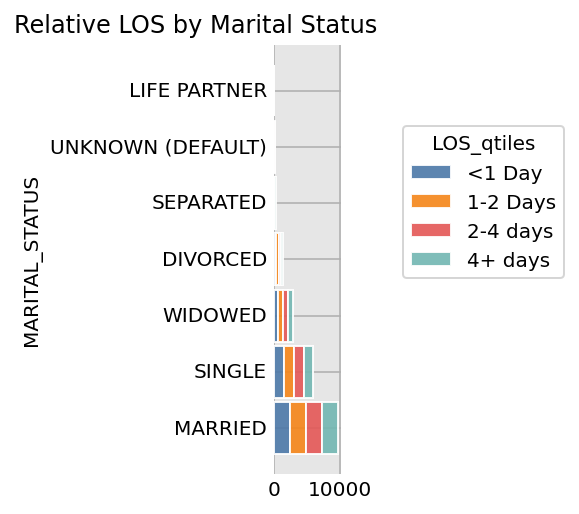

In [ ]:
import dexplot as dxp
dxp.count('MARITAL_STATUS', data=train, split='LOS_qtiles', 
        #  normalize=['MARITAL_STATUS'], 
          orientation='h', stacked=True, title='Relative LOS by Marital Status')

Not a whole lot to be gleaned from this

In [ ]:
train['MARITAL_STATUS'] = train['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
test['MARITAL_STATUS'] = test['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

Gender

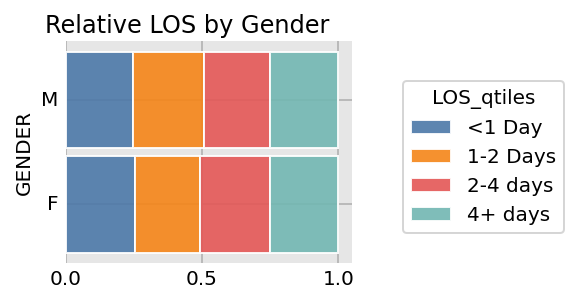

In [ ]:
dxp.count('GENDER', data=train, split='LOS_qtiles', 
          normalize=['GENDER'], 
          orientation='h', stacked=True, title='Relative LOS by Gender')

Relative frequency is almost even, despite there being more males. Perhaps dropping my gender variable won't impact my predictions.


Repeat Visits

Add up repeat visits. I realize my original repeat visits function from the last notebook did not match, and may have impacted my predictions slightly


In [ ]:

train["repeat"] = train.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1
test["repeat"] = test.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1

Ethnicity

Unable to Obtain likely means they were not able to answer and thus incapacitated, which is important to keep isolated


In [ ]:
train = train.replace(to_replace ='ASIAN - JAPANESE', value = 'ASIAN')
train = train.replace(to_replace ='ASIAN - KOREAN', value = 'ASIAN')
train = train.replace(to_replace ='ASIAN - THAI', value = 'ASIAN')
train = train.replace(to_replace ='ASIAN - FILIPINO', value = 'ASIAN')
train = train.replace(to_replace ='ASIAN - CAMBODIAN', value = 'ASIAN')
train = train.replace(to_replace ='ASIAN - OTHER', value = 'ASIAN')
train = train.replace(to_replace ='ASIAN - CHINESE', value = 'ASIAN')
train = train.replace(to_replace ='ASIAN - VIETNAMESE', value = 'ASIAN')
train = train.replace(to_replace ='ASIAN - ASIAN INDIAN', value = 'ASIAN')
train = train.replace(to_replace ='HISPANIC/LATINO - COLOMBIAN', value = 'HISPANIC/LATINO')
train = train.replace(to_replace ='HISPANIC/LATINO - PUERTO RICAN', value = 'HISPANIC/LATINO')
train = train.replace(to_replace ='HISPANIC/LATINO - SALVADORAN', value = 'HISPANIC/LATINO')
train = train.replace(to_replace ='HISPANIC/LATINO - HISPANIC OR LATINO', value = 'HISPANIC/LATINO')
train = train.replace(to_replace ='HISPANIC/LATINO - MEXICAN', value = 'HISPANIC/LATINO')
train = train.replace(to_replace ='HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', value = 'HISPANIC/LATINO')
train = train.replace(to_replace ='HISPANIC/LATINO - CUBAN', value = 'HISPANIC/LATINO')
train = train.replace(to_replace ='HISPANIC/LATINO - GUATEMALAN', value = 'HISPANIC/LATINO')
train = train.replace(to_replace ='HISPANIC/LATINO - HONDURAN', value = 'HISPANIC/LATINO')
train = train.replace(to_replace ='HISPANIC/LATINO - DOMINICAN', value = 'HISPANIC/LATINO')

train = train.replace(to_replace ='HISPANIC OR LATINO', value = 'HISPANIC/LATINO')

train = train.replace(to_replace ='BLACK/AFRICAN', value = 'BLACK')
train = train.replace(to_replace ='BLACK/CAPE VERDEAN', value = 'BLACK')
train = train.replace(to_replace ='BLACK/AFRICAN AMERICAN', value = 'BLACK')
train = train.replace(to_replace ='BLACK/HAITIAN', value = 'BLACK')
train = train.replace(to_replace ='WHITE - EASTERN EUROPEAN', value = 'WHITE')
train = train.replace(to_replace ='WHITE - BRAZILIAN', value = 'WHITE')
train = train.replace(to_replace ='WHITE - RUSSIAN', value = 'WHITE')
train = train.replace(to_replace ='WHITE - OTHER EUROPEAN', value = 'WHITE')

train = train.replace(to_replace ='AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', value = 'AMERICAN INDIAN/ALASKA NATIVE')

train = train.replace(to_replace ='PATIENT DECLINED TO ANSWER', value = 'OTHER')

# Same for test
test = test.replace(to_replace ='ASIAN - JAPANESE', value = 'ASIAN')
test = test.replace(to_replace ='ASIAN - KOREAN', value = 'ASIAN')
test = test.replace(to_replace ='ASIAN - THAI', value = 'ASIAN')
test = test.replace(to_replace ='ASIAN - FILIPINO', value = 'ASIAN')
test = test.replace(to_replace ='ASIAN - CAMBODIAN', value = 'ASIAN')
test = test.replace(to_replace ='ASIAN - OTHER', value = 'ASIAN')
test = test.replace(to_replace ='ASIAN - CHINESE', value = 'ASIAN')
test = test.replace(to_replace ='ASIAN - VIETNAMESE', value = 'ASIAN')
test = test.replace(to_replace ='ASIAN - ASIAN INDIAN', value = 'ASIAN')
test = test.replace(to_replace ='HISPANIC/LATINO - COLOMBIAN', value = 'HISPANIC/LATINO')
test = test.replace(to_replace ='HISPANIC/LATINO - PUERTO RICAN', value = 'HISPANIC/LATINO')
test = test.replace(to_replace ='HISPANIC/LATINO - SALVADORAN', value = 'HISPANIC/LATINO')
test = test.replace(to_replace ='HISPANIC/LATINO - HISPANIC OR LATINO', value = 'HISPANIC/LATINO')
test = test.replace(to_replace ='HISPANIC/LATINO - MEXICAN', value = 'HISPANIC/LATINO')
test = test.replace(to_replace ='HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', value = 'HISPANIC/LATINO')
test = test.replace(to_replace ='HISPANIC/LATINO - CUBAN', value = 'HISPANIC/LATINO')
test = test.replace(to_replace ='HISPANIC/LATINO - GUATEMALAN', value = 'HISPANIC/LATINO')
test = test.replace(to_replace ='HISPANIC/LATINO - HONDURAN', value = 'HISPANIC/LATINO')
test = test.replace(to_replace ='HISPANIC/LATINO - DOMINICAN', value = 'HISPANIC/LATINO')

test = test.replace(to_replace ='HISPANIC OR LATINO', value = 'HISPANIC/LATINO')

test = test.replace(to_replace ='BLACK/AFRICAN', value = 'BLACK')
test = test.replace(to_replace ='BLACK/CAPE VERDEAN', value = 'BLACK')
test = test.replace(to_replace ='BLACK/AFRICAN AMERICAN', value = 'BLACK')
test = test.replace(to_replace ='BLACK/HAITIAN', value = 'BLACK')
test = test.replace(to_replace ='WHITE - EASTERN EUROPEAN', value = 'WHITE')
test = test.replace(to_replace ='WHITE - BRAZILIAN', value = 'WHITE')
test = test.replace(to_replace ='WHITE - RUSSIAN', value = 'WHITE')
test = test.replace(to_replace ='WHITE - OTHER EUROPEAN', value = 'WHITE')

test = test.replace(to_replace ='AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', value = 'AMERICAN INDIAN/ALASKA NATIVE')

test = test.replace(to_replace ='PATIENT DECLINED TO ANSWER', value = 'OTHER')




In [ ]:
#Check values
train_eth = train.copy()
test_eth = test.copy()

print(pd.value_counts(test['ETHNICITY'])) #/ len(test4['ETHNICITY']))

WHITE                                        3849
BLACK                                         532
HISPANIC/LATINO                               203
OTHER                                         158
UNKNOWN/NOT SPECIFIED                         154
ASIAN                                         144
UNABLE TO OBTAIN                              140
PORTUGUESE                                     17
MULTI RACE ETHNICITY                           12
MIDDLE EASTERN                                  8
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       2
AMERICAN INDIAN/ALASKA NATIVE                   1
CARIBBEAN ISLAND                                1
Name: ETHNICITY, dtype: int64


In [ ]:
#Replace those below 100 with other
train = train.replace(to_replace ='AMERICAN INDIAN/ALASKA NATIVE', value = 'OTHER')
train = train.replace(to_replace ='CARIBBEAN ISLAND', value = 'OTHER')
train = train.replace(to_replace ='PORTUGUESE', value = 'OTHER')
train = train.replace(to_replace ='MIDDLE EASTERN', value = 'OTHER')
train = train.replace(to_replace ='MULTI RACE ETHNICITY', value = 'OTHER')
train = train.replace(to_replace ='NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', value = 'OTHER')
train = train.replace(to_replace ='SOUTH AMERICAN', value = 'OTHER')


test = test.replace(to_replace ='AMERICAN INDIAN/ALASKA NATIVE', value = 'OTHER')
test = test.replace(to_replace ='CARIBBEAN ISLAND', value = 'OTHER')
test = test.replace(to_replace ='PORTUGUESE', value = 'OTHER')
test = test.replace(to_replace ='MIDDLE EASTERN', value = 'OTHER')
test = test.replace(to_replace ='MULTI RACE ETHNICITY', value = 'OTHER')
test = test.replace(to_replace ='NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', value = 'OTHER')



In [ ]:
#Look at ratio
print(pd.value_counts(test['ETHNICITY']) / len(test['ETHNICITY']))

WHITE                    0.737215
BLACK                    0.101896
HISPANIC/LATINO          0.038881
OTHER                    0.038115
UNKNOWN/NOT SPECIFIED    0.029496
ASIAN                    0.027581
UNABLE TO OBTAIN         0.026815
Name: ETHNICITY, dtype: float64


In [ ]:
test['ETHNICITY'] = test['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED'
                                                     ], 'UNKNOWN')
train['ETHNICITY'] = train['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED'], 'UNKNOWN')


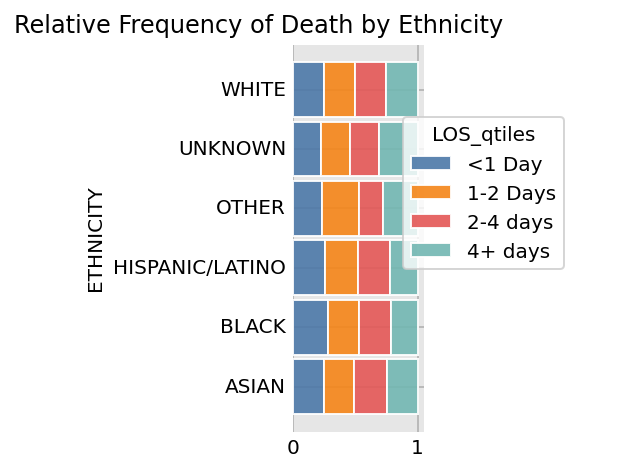

In [ ]:
dxp.count('ETHNICITY', data=train, split='LOS_qtiles', 
          normalize=['ETHNICITY'], 
          orientation='h', stacked=True, title='Relative Frequency of Death by Ethnicity')

Unable to obtain (perhaps due to being incapacitated) and unknown might be the only significant ones here, notice they tend to stay the longest.

Insurance (interesting!)

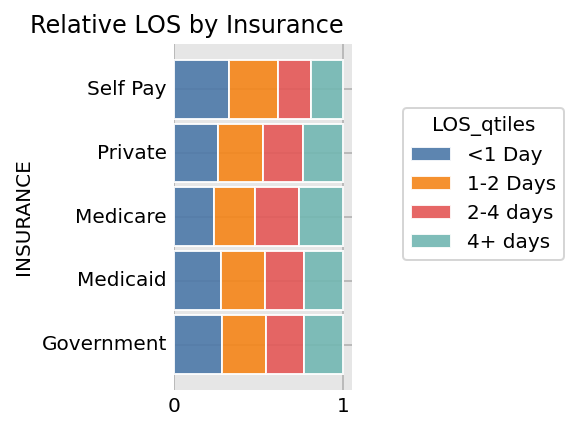

In [ ]:
dxp.count('INSURANCE', data=train, split='LOS_qtiles', 
          normalize=['INSURANCE'], 
          orientation='h', stacked=True, title='Relative LOS by Insurance')

It seems that Medicate patients tended to stay the longest, while self-pay the shortest. This makes a lot of sense as self-pay will want to leave as quickly as possible to avoid a hefty bill.

Religion



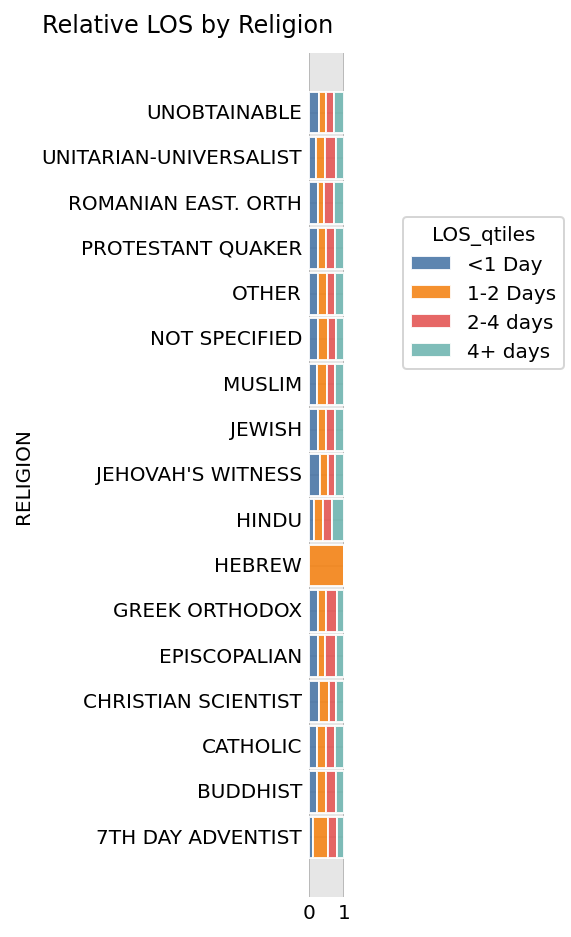

In [ ]:
dxp.count('RELIGION', data=train, split='LOS_qtiles', 
          normalize=['RELIGION'], 
          orientation='h', stacked=True, title='Relative LOS by Religion')

It would have been more interesting if there are religions that refuse treatment but none pop out.

In [ ]:
#From model solution
religion_other = ['HEBREW', 'UNITARIAN-UNIVERSALIST', 'HINDU', 'GREEK ORTHODOX',"JEHOVAH'S WITNESS", "BUDDHIST", 'MUSLIM', 'OTHER', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'ROMANIAN EAST. ORTH', '7TH DAY ADVENTIST'] 
train['RELIGION'] = train['RELIGION'].replace(religion_other, 'OTHER')
test['RELIGION'] = test['RELIGION'].replace(religion_other, 'OTHER')

Diagnosis

Inspect top diagnoses and how often they relate to length of stay

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


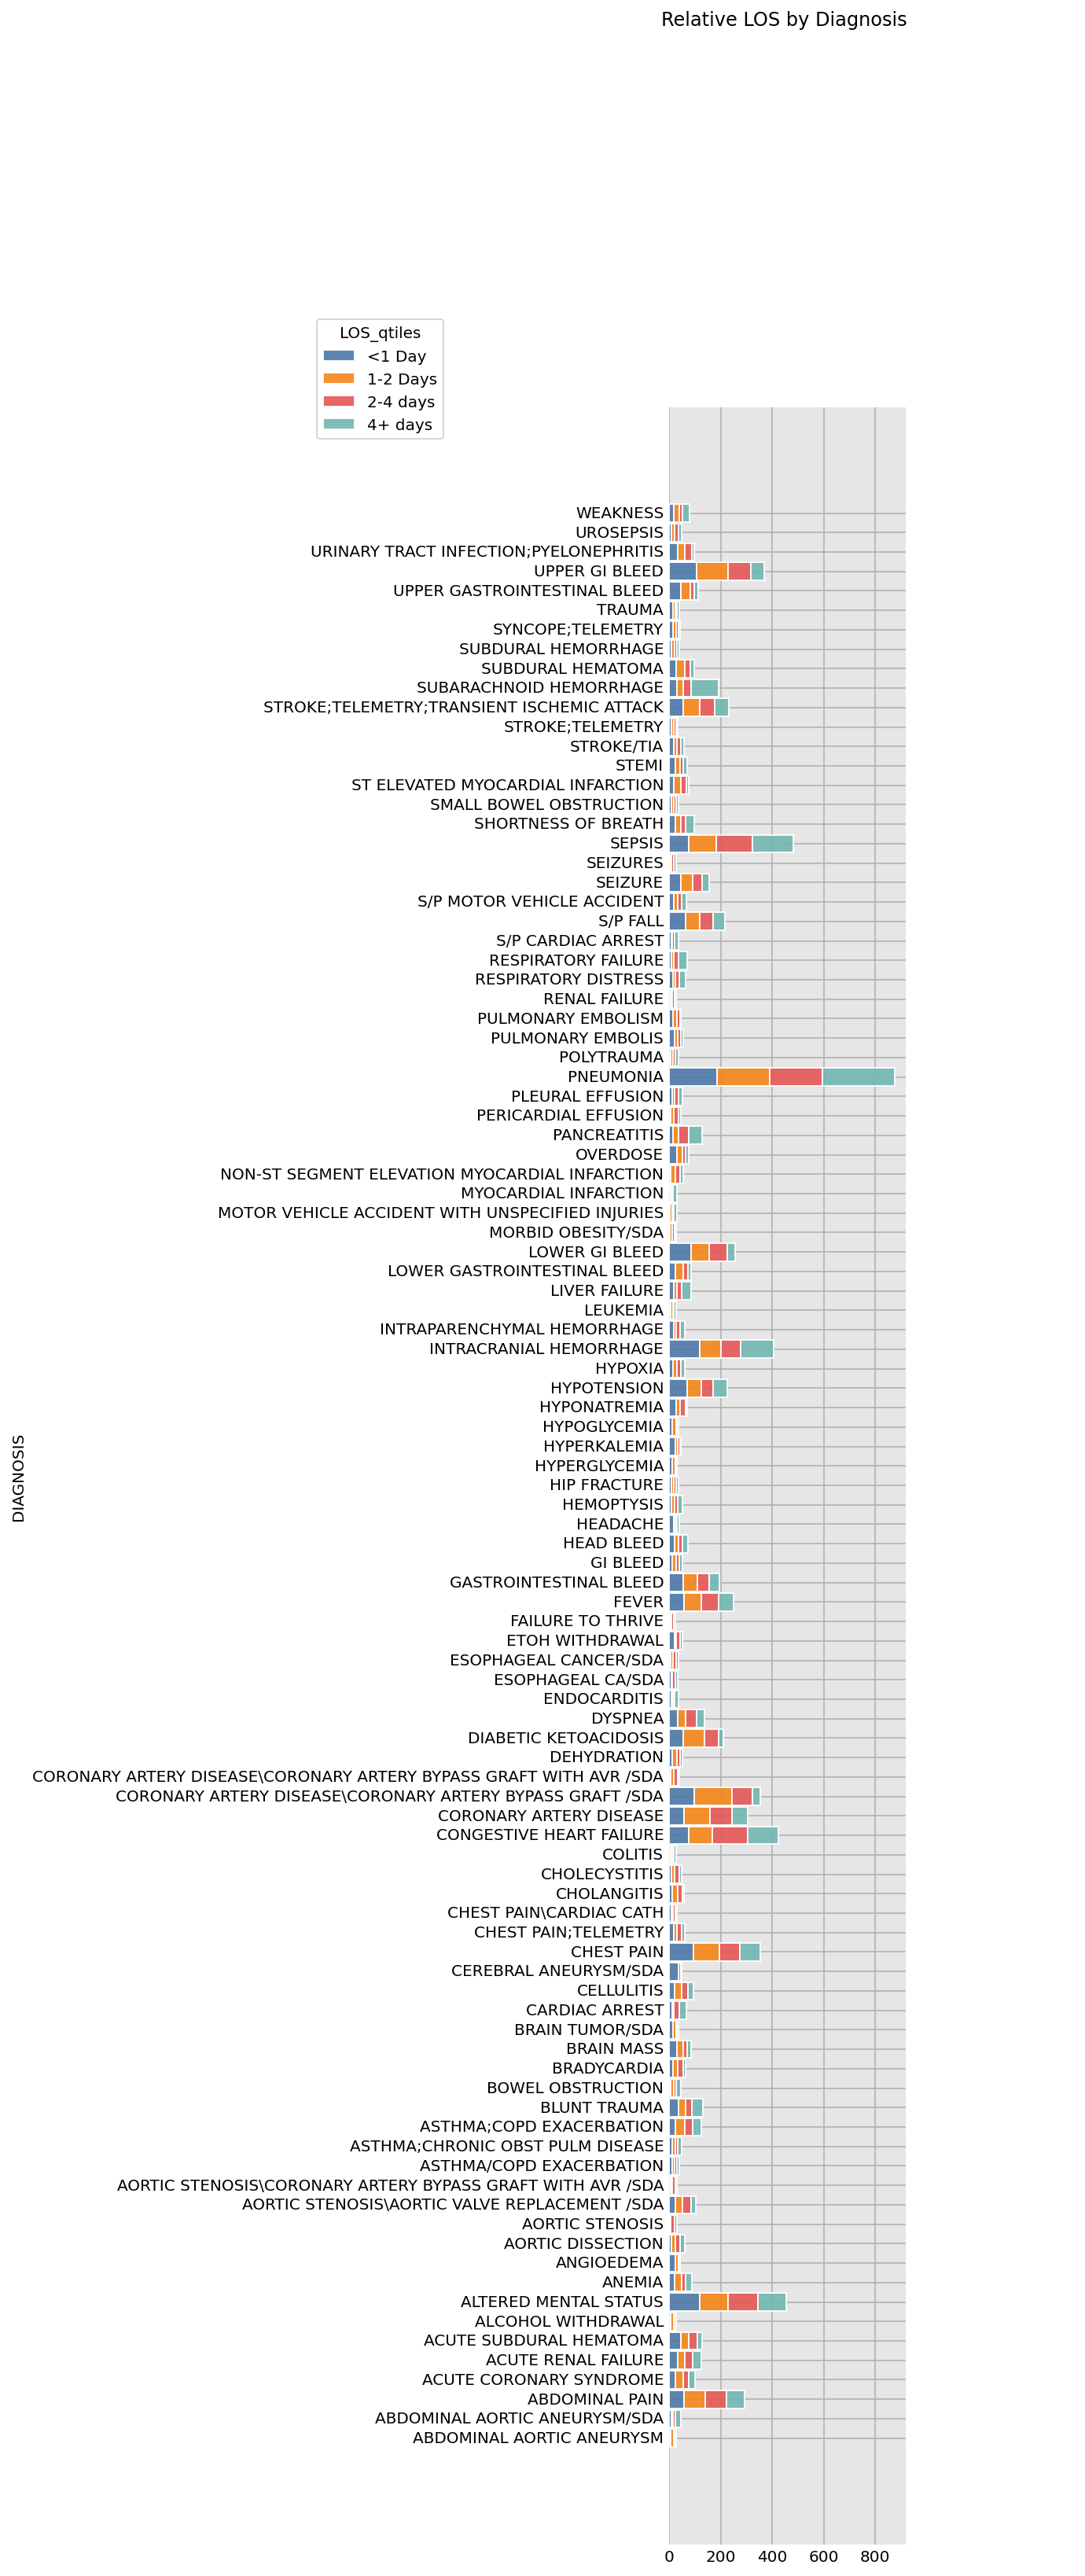

In [ ]:
dxp.count('DIAGNOSIS', data=train, split='LOS_qtiles', 
          #normalize=['DIAGNOSIS'], 
          y_order='top 100',
          orientation='h', stacked=True, title='Relative LOS by Diagnosis')

Normalized

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


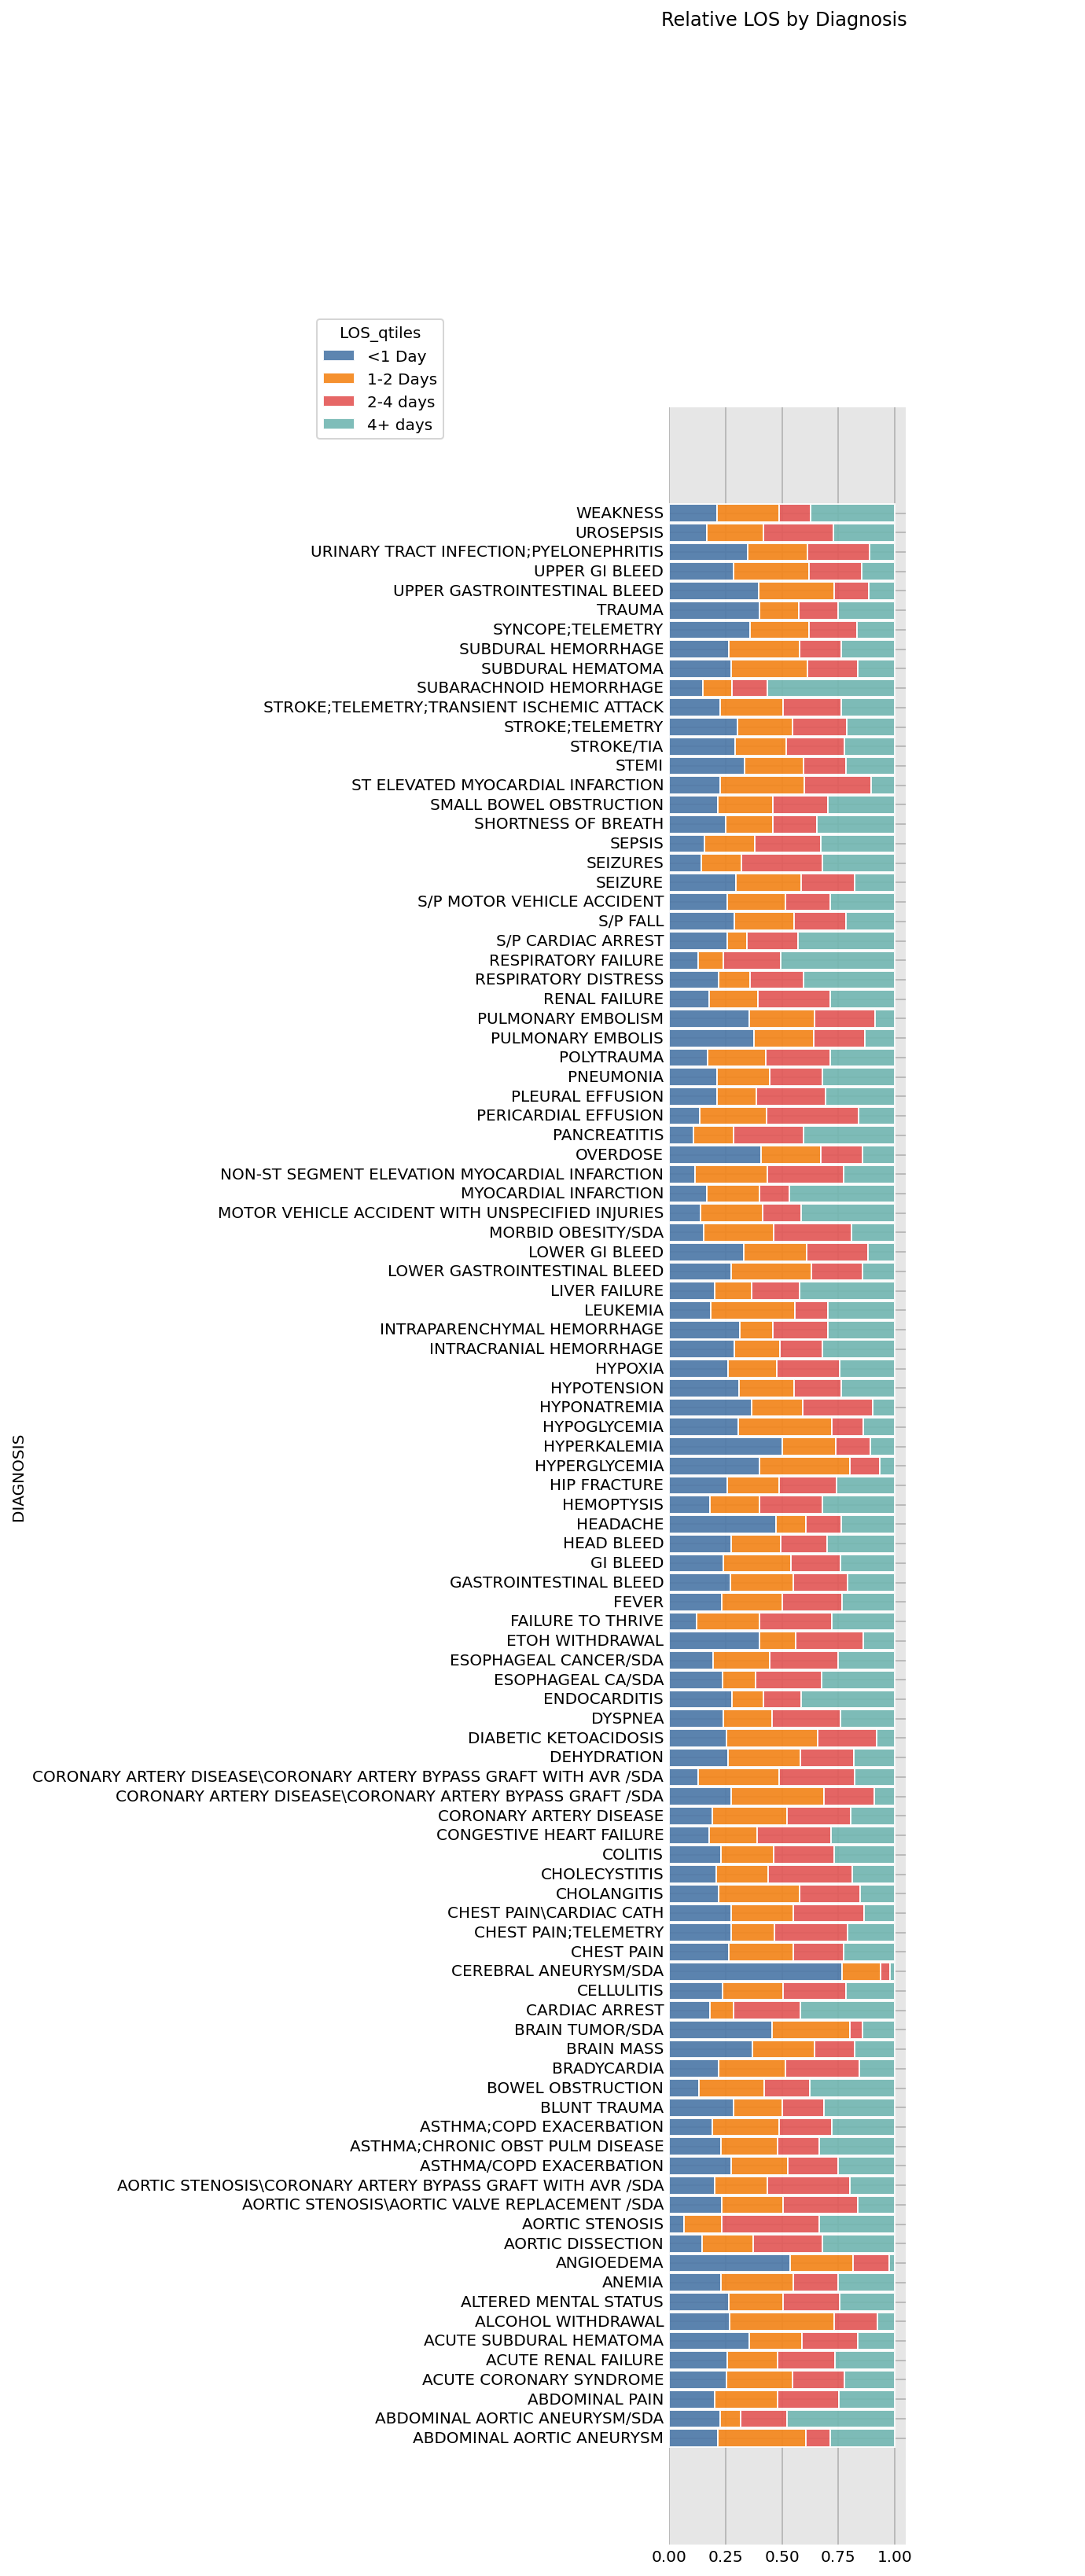

In [ ]:
dxp.count('DIAGNOSIS', data=train, split='LOS_qtiles', 
          normalize=['DIAGNOSIS'], 
          y_order='top 100', split_order='asc',
          orientation='h', stacked=True, title='Relative LOS by Diagnosis')

This is probably my most interesting plot. There are a lot of interesting take-aways here that I hope my algorithm will pick out.

The biggest take aways here are the cardiac arrest, endocarditis, respiratory failure, and subarachnoid hemorrhage are longer stays. I will create a separate dummy for those for now.

Pneumonia and Cardiac Arrest

In [ ]:
#Inspect pneumonia further to see correlation with age
pneumonia = train[train['DIAGNOSIS'].str.contains("PNEUMONIA")]

In [ ]:
cardiac = train[train['DIAGNOSIS'].str.contains("CARDIAC")]

Can see below that Pneumonia length of stays tend to be longer the older you get

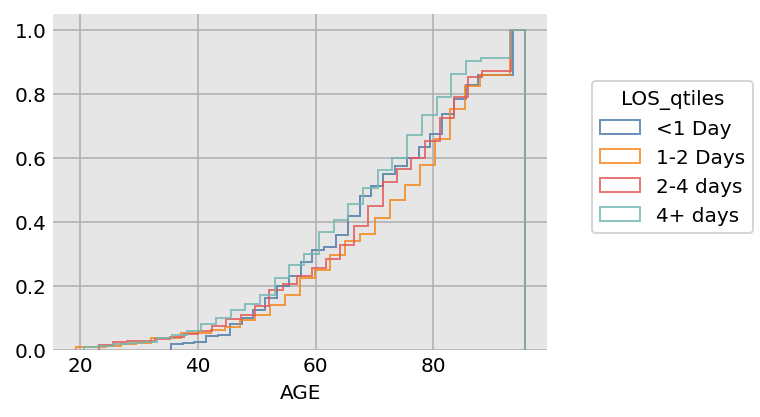

In [ ]:
dxp.hist(val='AGE', data=pneumonia, split='LOS_qtiles',
         bins=30, density=True, histtype='step', cumulative=True)

The stay gets longer for those with pneumonia at an older age

In [ ]:
#Create checkpoints throughout to come back to if I make a mistake during transformations
checkpoint1 = train.copy()
chckpoint2 = train.copy()
train = chckpoint2.copy()

In [ ]:
#Create Cardiac dummy
train['PNEUMONIA'] = 0
train.loc[train['DIAGNOSIS'].str.contains('PNEUMONIA'), 'PNEUMONIA'] = 1

#Create Cardiac dummy
train['CARDIAC'] = 0
train.loc[train['DIAGNOSIS'].str.contains('CARDIAC'), 'CARDIAC'] = 1

#Create intracranial hemorrhage dummy
train['SUBARACHNOID HEMORRHAGE'] = 0
train.loc[train['DIAGNOSIS'].str.contains('SUBARACHNOID'), 'SUBARACHNOID HEMORRHAGE'] = 1

#Create cerebral dummy
train['CEREBRAL'] = 0
train.loc[train['DIAGNOSIS'].str.contains('CEREBRAL'), 'CEREBRAL'] = 1

#FOR TEST SET
#Create Cardiac dummy
test['PNEUMONIA'] = 0
test.loc[train['DIAGNOSIS'].str.contains('PNEUMONIA'), 'PNEUMONIA'] = 1

#Create Cardiac dummy
test['CARDIAC'] = 0
test.loc[train['DIAGNOSIS'].str.contains('CARDIAC'), 'CARDIAC'] = 1

#Create intracranial hemorrhage dummy
test['SUBARACHNOID HEMORRHAGE'] = 0
test.loc[train['DIAGNOSIS'].str.contains('SUBARACHNOID'), 'SUBARACHNOID HEMORRHAGE'] = 1

#Create cerebral dummy
test['CEREBRAL'] = 0
test.loc[train['DIAGNOSIS'].str.contains('CEREBRAL'), 'CEREBRAL'] = 1

In [ ]:
train['CEREBRAL'].value_counts()

0    20806
1       79
Name: CEREBRAL, dtype: int64

Unlike Pneumonia, you can see that those who have cardiac arrest tend to have medium stays in their 60s and 70s, when heart attacks are likelier. 

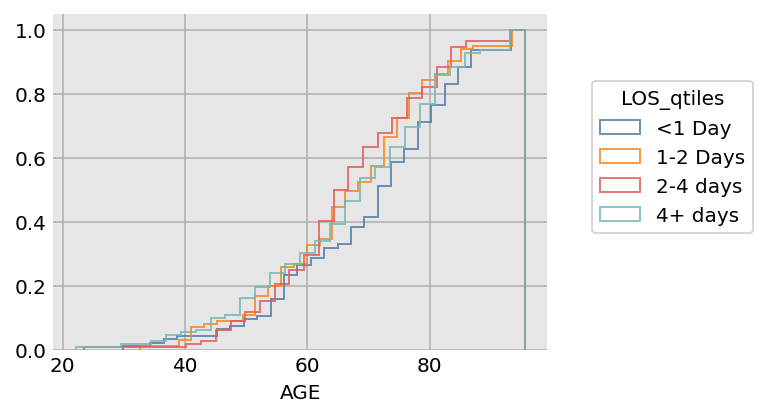

In [ ]:
dxp.hist(val='AGE', data=cardiac, split='LOS_qtiles',
         bins=30, density=True, histtype='step', cumulative=True)

In [ ]:
#New checkpoint
checkpoint = train.copy()
testpoint = test.copy()

### Encoding

I end up taking care of encoding in the preprocessing pipeline, but I considered three main encoders: Target, LeaveOneOut, and Hashing. I included a graphic in the appendix that I used to decide. Target is great for high cardinality features like Diagnosis, and LeaveOneOut is better because it prevents overfitting by tuning the sigma value and leaving the related y observation out of the encoded observation as it fits. 


In [ ]:
Xtr['DIAGNOSIS'] = raw_train['DIAGNOSIS']
Xtr_test['DIAGNOSIS'] = raw_test['DIAGNOSIS']

In [ ]:
#Will skip using this for now in favor of preprocessing pipeline

h = HashingEncoder(cols=("DIAGNOSIS"), n_components = 9)

Xtr = h.fit_transform(train, y=y)
Xtr_test = h.transform(test)

In [ ]:
Xtr.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
       'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'ADMITTIME',
       'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'ICD9_diagnosis', 'FIRST_CAREUNIT', 'AGE', 'AGEBIN',
       'ADMITBINS', 'ADMITMONTH', 'SEASON', 'visit_cmbs', 'comorbs_bins',
       'los_proxy', 'max_los', 'mean_los', 'HeartRate_Range', 'SysBP_Range',
       'DiasBP_Range', 'MeanBP_Range', 'RespRate_Range', 'TempC_Range',
       'SpO2_Range', 'Glucose_Range', 'PulsePressure_Min',
       'PulsePressure_Mean', 'PulsePressure_Max', 'PulsePressure_Range',
 

In [ ]:
Xtr = Xtr.drop(['LOS_binary'], axis=1)
Xtr_test = Xtr_test.drop(['LOS_binary'], axis=1)

## Pipeline Transformations



First I will try to impute NAs based on prior admission data matching on subject_id. If data is NA, I will fill it in with that person's prior. 

This method did not fill in a lot of NAs, but did fill in some (I noticed a 30 or so increase and 15 in the test set).



In [ ]:
#Backfill from prior visits
bfill = train.copy()
bfill_test = test.copy()

train = bfill.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())
test = bfill_test.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())

cpoint = train.copy()
cpointtest=test.copy()
#Now I need to drop the subject ids
# train = train.drop(["subject_id"], axis=1)
# test = test.drop(["subject_id"], axis=1)

### Transform Y 
Looked into log transforming here given skewness of the LOS data

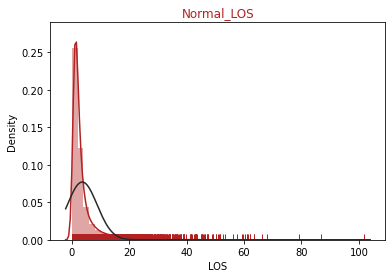

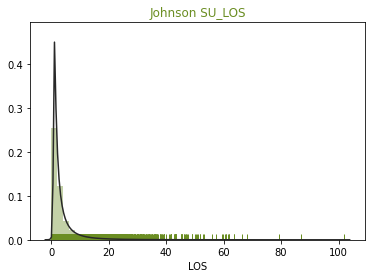

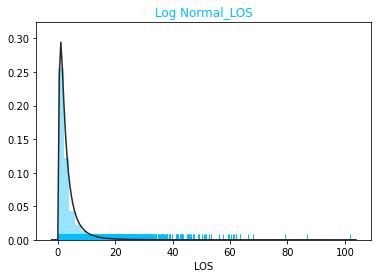

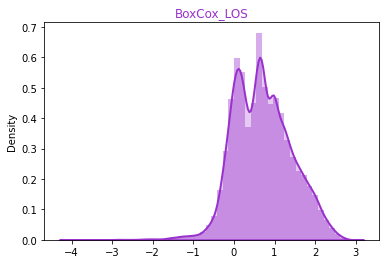

In [ ]:
#inspect y variable distribution and possible transformations

#plot normal
plt.figure(1); plt.title('Normal_LOS', color = 'firebrick')
sns.distplot(y, kde=True, rug=True, fit=st.norm, color='firebrick')

#plot johnson_su
plt.figure(2); plt.title('Johnson SU_LOS', color='olivedrab')
sns.distplot(y, kde=False,rug=True, fit=st.johnsonsu, color='olivedrab')

#plot log
plt.figure(3); plt.title('Log Normal_LOS', color='deepskyblue')
sns.distplot(y, kde=False, rug=True, fit=st.lognorm,  color='deepskyblue')

#plot boxcox and notice it gives a near perfectly normal distribution to deal with outliers
y_box, lambda_box = st.boxcox(y)

#%%
plt.figure(4); plt.title('BoxCox_LOS', color='darkorchid') 
sns.distplot(y_box, kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "BoxCox", color ="darkorchid")
#kde plots a gaussian kernel density

The boxcox seems to have done well in making it more normally distributed, so I tried to use it as my primary y. However, after trying it for a while, I've come to the conclusion that it didn't really improve my predictions by much, if any. 

In [ ]:
# #Log transform ys
# y_log10 = np.log10(y_train)
# y_log2 = np.log2(y_train)
# y_log = np.log(y_train)

#Boxcox transform
y_box, lambda_box = st.boxcox(train['LOS'])

#Code for returning from boxcox for test prediction submission
#submission_bcx = inv_boxcox(y_predtestbcx, lambda_box)

### Create sets of input features

I tried out many combinations of input features in addition to using SHAP and Ensemble Methods for feature selection. 

As it got confusing keeping track of what I was using, I just manually laid them out so I could toggle them on and off when trying out predictions. 

I then appended all of the combinations to a series, and ran all of them through the Grid Searches.

In [ ]:
chck, tstp = train.copy(), test.copy()
train = drop_LOStiles(train)
train = drop_LOS(train)
train, test = drop_ids(train, test)
train, test = drop(train, test, 'uniquer_id')

In [ ]:
for i in train:
  if i not in test:
    print(i)

In [ ]:
train1, test1 = train.copy(), test.copy()
#trainnums, testnums = drop_dums(train, test)
#train1 = train1.drop(['ICD9_diagnosis'], axis=1)
#test1 = test1.drop(['ICD9_diagnosis'], axis=1)

train1, test1 = leaveoneencode(train1, test1, 'DIAGNOSIS', 3)
#train1, test1 = targetencode(train1, test1, ['ICD9_diagnosis'], .92)

#Play with commenting out various variables
#train1, test1 = drop(train1, test1,'ADMITTIME')
#train1, test1 = drop(train1, test1,'ADMITMONTH')
# train1, test1 = drop(train1, test1, 'ADMITBINS')
#train1, test1 = drop(train1, test1, 'ADMISSION_TYPE')
#train1, test1 = drop(train1, test1, 'DIAGNOSIS')
# train1, test1 = drop(train1, test1, 'ETHNICITY')
# train1, test1 = drop(train1, test1, 'AGEBIN')
# train1, test1 = drop(train1, test1, 'AGE')
# train1, test1 = drop(train1, test1, 'SEASON')
# train1, test1 = drop(train1, test1, 'INSURANCE')
# train1, test1 = drop(train1, test1, 'FIRST_CAREUNIT')
# train1, test1 = drop(train1, test1, 'RELIGION')
# train1, test1 = drop(train1, test1, 'comorbs_bins')
# train1, test1 = drop(train1, test1, 'MARITAL_STATUS')
# train1, test1 = drop(train1, test1, 'GENDER')
# train1, test1 = drop(train1, test1, 'repeat')
train1, test1 = drop(train1, test1, 'CEREBRAL')
train1, test1 = drop(train1, test1, 'PNEUMONIA')
train1, test1 = drop(train1, test1, 'CARDIAC')
train1, test1 = drop(train1, test1, 'SUBARACHNOID HEMORRHAGE')
# train1, test1 = drop(train1, test1, 'ADMISSION_SEVERITY')
# train1, test1 = drop(train1, test1, 'HeartRate_Min')
# train1, test1 = drop(train1, test1, 'HeartRate_Max')
# train1, test1 = drop(train1, test1, 'HeartRateMax_Age')
# train1, test1 = drop(train1, test1, 'HeartRate_Range')
# train1, test1 = drop(train1, test1, 'HeartRate_Mean')
# train1, test1 = drop(train1, test1, 'SysBP_Min')
# train1, test1 = drop(train1, test1, 'SysBP_Max')
# train1, test1 = drop(train1, test1, 'SysBP_Range')
# train1, test1 = drop(train1, test1, 'SysBP_Mean')
# train1, test1 = drop(train1, test1, 'DiasBP_Min')
# train1, test1 = drop(train1, test1, 'DiasBP_Max')
# train1, test1 = drop(train1, test1, 'DiasBP_Range')
# train1, test1 = drop(train1, test1, 'DiasBP_Mean')
# train1, test1 = drop(train1, test1, 'MeanBP_Min')
# train1, test1 = drop(train1, test1, 'MeanBP_Max')
# train1, test1 = drop(train1, test1, 'MeanBP_Range')
# train1, test1 = drop(train1, test1, 'MeanBP_Mean')
# train1, test1 = drop(train1, test1, 'RespRate_Min')
# train1, test1 = drop(train1, test1, 'RespRate_Max')
# train1, test1 = drop(train1, test1, 'RespRate_Range')
# train1, test1 = drop(train1, test1, 'RespRate_Mean')
# train1, test1 = drop(train1, test1, 'TempC_Min')
# train1, test1 = drop(train1, test1, 'TempC_Max')
# train1, test1 = drop(train1, test1, 'TempC_Range')
# train1, test1 = drop(train1, test1, 'TempC_Mean')
# train1, test1 = drop(train1, test1, 'SpO2_Min')
# train1, test1 = drop(train1, test1, 'SpO2_Max')
# train1, test1 = drop(train1, test1, 'SpO2_Range')
# train1, test1 = drop(train1, test1, 'SpO2_Mean')
# train1, test1 = drop(train1, test1, 'Glucose_Min')
# train1, test1 = drop(train1, test1, 'Glucose_Max')
# train1, test1 = drop(train1, test1, 'Glucose_Range')
# train1, test1 = drop(train1, test1, 'Glucose_Mean')
# train1, test1 = drop(train1, test1, 'PulsePressure_Min')
# train1, test1 = drop(train1, test1, 'PulsePressure_Max')
# train1, test1 = drop(train1, test1, 'PulsePressure_Range')
# train1, test1 = drop(train1, test1, 'PulsePressure_Mean')

#train1 = pd.get_dummies(train1, drop_first=True)
#test1 = pd.get_dummies(test1, drop_first=True)

In [ ]:
# #Create new training sets to drop variables
# train1, test1 = simpleimpute(train1, test1)
# train2, test2 = drop_maxes(train1, test1)
# train3, test3 = drop_mins(train1, test1)
# train4, test4 = drop_ranges(train1, test1)
# train5, test5 = PCA_func(train2, test2, 12)
# train6, test6 = polynomial(train2, test2, 2)


In [ ]:
for i in train1:
  if i not in test1:
    print(i)

### XGBoost without only continous
Here is basic SHAP, CV performance, and error in this baseline model with polynomial transformations.

In [ ]:
xp = train1.select_dtypes(exclude=['object', 'category'])
tp = test1.select_dtypes(exclude=['object', 'category'])
xp['LOS'] = chck['LOS']
#Use a simple function to quickly clean dataset (do not use this in final predictions)
clean_dataset(xp)
clean_dataset(tp)
y_cleaned = xp['LOS']
xp = xp.drop(['LOS'], axis=1)

#### Polynomial Transform

Ended up adding polynomial to my pipeline as it nearly always improved my predictions. 

In [ ]:
poly = PolynomialFeatures(2)
xpn = poly.fit_transform(xp)
tpn = poly.transform(tp)

In [ ]:
#XGboost on unpreprocessed data
xgb = XGBRegressor(reg_lambda= 1.5, objective= 'reg:squarederror', min_child_weight= 6, max_depth= 6, learning_rate= 0.05)
#y_boxs, lambda_boxs = st.boxcox(y_train_s)

cvs = cross_val_score(xgb, 
                      xpn, 
                      y_cleaned, 
                      scoring = 'neg_root_mean_squared_error', 
                      cv = 2)

# Fit on training data with y_log in first attempt
model = xgb.fit(xpn, y_cleaned)

preds = model.predict(tpn)

In [ ]:
cvs

array([-4.12056687, -4.17681534])

In [ ]:
preds

array([ 3.007595 , 14.645718 ,  4.3264313, ...,  2.5047204,  1.556511 ,
        1.8442572], dtype=float32)

In [ ]:
feat_names = poly.get_feature_names(xp.columns)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


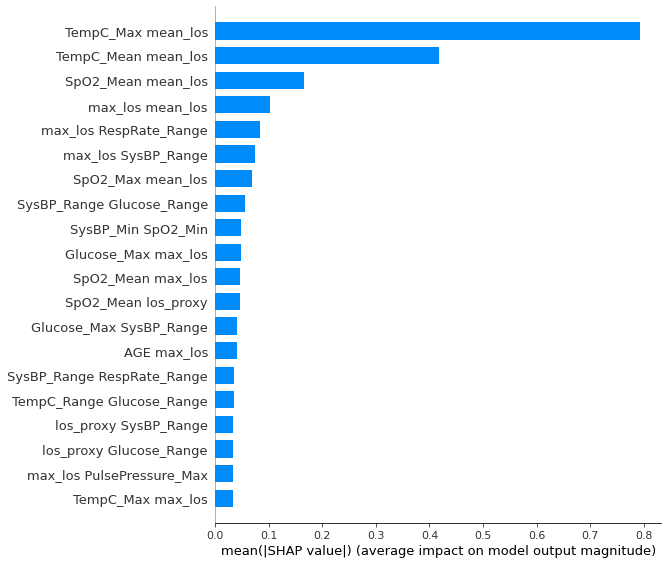

In [ ]:
explainer = shap.TreeExplainer(model) #(***) xgb_model is my trained xgboost model 
shap_values = explainer.shap_values(xpn)
shap.initjs()
shap.summary_plot(shap_values, feat_names, plot_type="bar")

Clearly, the los proxies from Philine's notebook made a big difference, particularly the mean_los variable. The ranges I created also seem to be useful

### Tutor Preprocessing Pipeline

Implementing the preprocessing pipeline that was uploaded to the model solutions repository, with some minor tweaks.

In [ ]:
train1 = Xtr.copy()
test1 = Xtr_test.copy()

In [ ]:
xx = train1.copy()
tt = test1.copy()
print(xx.shape)
print(tt.shape)
cat_feat = xx.select_dtypes(include=['object', 'category']).columns
icd9_feat = ['ICD9_diagnosis']
cat_feat = cat_feat.drop(['ICD9_diagnosis']) 
print(icd9_feat)
print(cat_feat)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

cont_imputer = SimpleImputer(strategy="mean", missing_values=np.nan)
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
cont_scaler = RobustScaler()
cat_scaler = StandardScaler()

# Update list of numerical and categorical features
num_feat = xx.select_dtypes(exclude=['object', 'category']).columns
print("Numerical Features:", num_feat)

cat_feat = xx.select_dtypes(include=['object', 'category']).columns

# make own category for preprocessing 'ICD9_diagnosis'
icd9_feat = ['ICD9_diagnosis']
cat_feat = cat_feat.drop(['ICD9_diagnosis']) 
print("ICD9 Feature:", icd9_feat)
print("Categorical Features:", cat_feat)

(20885, 71)
(5221, 71)
['ICD9_diagnosis']
Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT', 'AGEBIN', 'ADMITBINS', 'SEASON',
       'comorbs_bins'],
      dtype='object')
Numerical Features: Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
       'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'ADMITTIME', 'AGE',
       'ADMITMONTH', 'visit_cmbs', 'los_proxy', 'max_los', 'mean_los',
       'HeartRate_Range', 'SysBP_Range', 'DiasBP_Range', 'MeanBP_Range',
       'RespRate_Range', 'TempC_Range', 'SpO2_Range', 'Glucose_Range',
       'PulsePressure_Min', 

In [ ]:
checkpoint2, testpoint2 = xx.copy(), tt.copy()
#Save another checkpoint
cont_polynomial = PolynomialFeatures(2, include_bias = False)

# pipeline for numerical data
num_preprocessing = make_pipeline(
    cont_scaler,
    cont_imputer,
    cont_polynomial
    )
# pipeline for categorical data
cat_preprocessing = make_pipeline(
    #SimpleImputer(strategy="most_frequent"), # we only have missing data now in the continious 
    cat_encoder,
    cat_scaler)
  

icd9_encoder = ce.TargetEncoder(smoothing = 1.3)
icd9_preprocessing = make_pipeline(
    icd9_encoder,
    cat_scaler)



# combine preprocessing pipelines using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_feat),
     ("cat", cat_preprocessing, cat_feat),
     ("icd9", icd9_preprocessing, icd9_feat)
     ]
    ,remainder='passthrough'
    # ,remainder='drop'
    )



#pp = preprocessing.fit(xx, y)
#X_train_pp = preprocessing.transform(X_train)
Xtr = preprocessing.fit_transform(xx, y)

Xtr_test = preprocessing.transform(tt)


set_config(display="diagram")
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer()),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False))]),
                                 Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', '...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT', 'AGEBIN', 'ADMITBINS', 'SEASON',
       'comorbs_bins'],
      dtype='object')),
                                ('icd9',
                                 Pipeline(steps=[('targetencoder',
                                                  TargetEncoder(smoothing=1.3)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['ICD9_diagnosis'])])

In [ ]:
#As mentioned, I used the below to try out various combinations of feature sets for my randomized search

# sets =[]
# append_to_sets(Xtr, Xtr_test)
# append_to_sets(Xtr1, Xtr_test1)
# append_to_sets(Xtr2, Xtr_test2)
# append_to_sets(Xtr3, Xtr_test3)
# append_to_sets(Xtr4, Xtr_test4)
# append_to_sets(Xtr5, Xtr_test5)
# append_to_sets(Xtr6, Xtr_test6)
# append_to_sets(principalComponents, testPCA)
# append_to_sets(principalComponents1, testPCA1)


#### PCA

I tried many different PCAs and predictably all of them made my predictions worse (since trees aren't very senstive to correlation), although it might speed up training.  

In [ ]:
# pca = PCA(n_components=5)
# PCA = pca.fit_transform(Xtr)
# PCD_DF = pd.DataFrame(data = PCA)
# PCA_TEST = pca.transform(Xtr_test)
# pca.explained_variance_ratio_

# GridSearch



### Randomized Search

Below is the randomized search CV that I used. I used many different combinations in the parameters and saw a lot of different optimal parameters over time. I describe the parameters in a bit more detail later on.

In [ ]:
#At times this had 10 or so sets in it I would run through the gridsearch
sets = [(Xtr, Xtr_test)]

In [ ]:
#I eventually commented everything out but XGB as it continously performed the best

models = [XGBRegressor()]#,
 #         DecisionTreeRegressor(),
#          RandomForestRegressor()]#,
   #       AdaBoostRegressor(),
    #     GradientBoostingRegressor()]

# models parameters
xgb_params = {'objective':['reg:squarederror'],
                  'learning_rate': [.1],
                  'max_depth':[1, 2, 6],
                  'min_child_weight': [2, 4],
                  'reg_lambda':[2.8, 11.4],
                  'seed': [154],
                  'n_jobs':[-1],
                  'n_estimators':[132]}

# dectree_params = {'max_features': range(4, 10),
#                   'max_depth': range(3, 6),
#                   'min_samples_leaf': range(5, 10),
#                   'random_state': [SEED]}

# randomforest_params = {'max_features': [5, 15, 25, 75],
#                   'n_estimators': [50, 100, 139],
#                   'max_depth': [1, 3, 5, 11, 23],
#                   'min_samples_leaf': [3, 14, 29],
#                   'min_impurity_decrease': [0, 0.25, .43],
#                   'random_state': [4, 67, 238],
#                   'oob_score': [True, False],
#                   'verbose':[0, 1],
#                   'n_jobs':[-1],
#                   'warm_start':[True],
#                   'ccp_alpha':[0, .12, 2.2],
#                   'max_samples':[None, 3, 30]}

# adab_params = {'learning_rate': [0.05, 1],
#                   'n_estimators': [50, 100],
#                   'loss':['linear', 'square'],
#                   'random_state': [SEED]}

# gb_params = {'learning_rate': [0.05, 1],
#                   'n_estimators': [50, 100],
#                   'max_depth': range(3, 6),
#                 'max_features': range(4, 20),
#                   'random_state': [SEED]}

params = [xgb_params]#, randomforest_params]#, adab_params, gb_params]
names = ['XGB_Regressor']#, 'RandomForest_Regressor']#, 'AdaBoost_Regressor',
   #     'GradientBoosting_Regressor']
scores = {}

y_hats= pd.DataFrame(index=raw_test['icustay_id'])
# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = RandomizedSearchCV(model, params[i], cv=2, 
                              scoring=('neg_root_mean_squared_error'))
    counter = 1
    for j, k in sets:
      print("train",counter)
      best_model.fit(j, y_box)
      print(f"Best model fitted")
      y_hat = best_model.predict(k)
      y_hat = inv_boxcox(y_hat, lambda_box)
      y_hats[str(counter)] = y_hat
      counter += 1
    # mse = mean_squared_error(y, y_hat)
      #assign the best parameters to my models
      models[i].set_params(**best_model.best_params_)
      
      #print scores (on log parcelvalue)
      scores[names[i]] = (best_model.best_estimator_, mse)
      print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
      print(f'{names[i]} MSE score on train sample: {-best_model.best_score_}')

y_hats.to_csv("submit3.csv")

Grid-Searching for model XGB_Regressor...
train 1
Best model fitted
XGB_Regressor chosen hyperparameters: {'seed': 154, 'reg_lambda': 2.8, 'objective': 'reg:squarederror', 'n_jobs': -1, 'n_estimators': 132, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
XGB_Regressor MSE score on train sample: 0.5515775909696516


In [ ]:
y_hats['LOS'] = y_hat


ValueError: ignored

In [ ]:
y_hat

array([ 3.77936197, 18.22530735,  4.61563691, ...,  9.68699543,
        7.66800636,  7.30353475])

#### SHAP, Model Interpretation, and Individual Model Runs

Here is an example of SHAP to see which features were most important to the model, so that model interpretation is possible. The shapley value, or SHAP, is the average of the marginal contributions when considering every permutation.

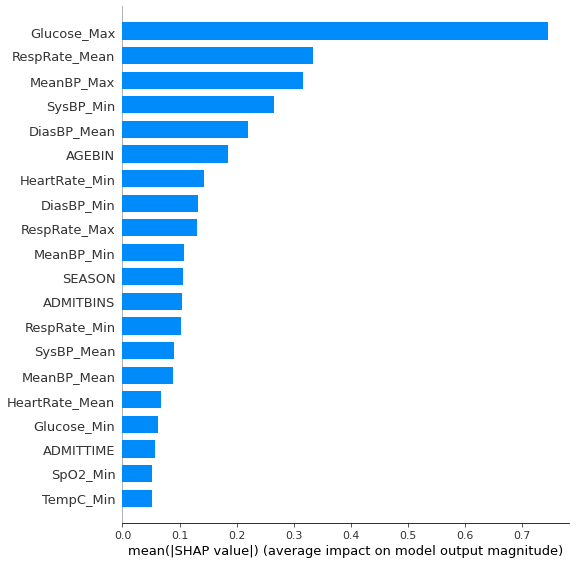

In [ ]:
      x = XGBRegressor(seed=4, reg_lambda=5, objective= 'reg:squarederror', min_child_weight= 11, max_depth= 3, learning_rate= 0.1)
      x.fit(train5, y)
      explainer = shap.TreeExplainer(x) #(***) xgb_model is my trained xgboost model 
      shap_values = explainer.shap_values(train5)
      shap.initjs()
      shap.summary_plot(shap_values, train1.columns, plot_type="bar")

Some optimal XGB parameters I saw over time

```
#{'seed': 238, 'reg_lambda': 12.2, 'objective': 'reg:squarederror', 'n_jobs': -1, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.2}
#{'seed': 4, 'reg_lambda': 27, 'objective': 'reg:squarederror', 'n_jobs': -1, 'n_estimators': 888, 'min_child_weight': 24, 'max_depth': 1, 'learning_rate': 0.1}```



In [ ]:
# xg = XGBRegressor(seed= 4, reg_lambda= 27, objective= 'reg:squarederror', n_jobs= -1, n_estimators= 888, min_child_weight= 24, max_depth= 1, learning_rate= 0.1)
# xg.fit(Xtr, y)
# xg_hat = xg.predict(Xtr_test)
# xg_hats= pd.DataFrame(index=raw_test['icustay_id'])
# xg_hats['LOS'] = xg_hat
# xg_hats.to_csv('xgboost2.csv')

In [ ]:
# xg_hats= pd.DataFrame(index=raw_test['icustay_id'])
# xg_hats['LOS'] = xg_hat
# xg_hats.to_csv('xgboost.csv')

In [ ]:
# test_predictions_submit = pd.DataFrame({"icustay_id": test["icustay_id"], "LOS": y_hat})
# test_predictions_submit.to_csv("gridsearch.csv", index = False)

For reference, my results from my initial grid search show XGB to produce the lowest MSE were not great.

```
Grid-Searching for model XGB_Regressor...
Best model fitted
XGB_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 8, 'objective': 'reg:squarederror', 'reg_lambda': 1.5, 'seed': 238}
XGB_Regressor MSE score on train sample: 4.7747391431665624
Grid-Searching for model RandomForest_Regressor...
Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 12, 'n_estimators': 100, 'random_state': 238}
RandomForest_Regressor MSE score on train sample: 4.816653626820222
Grid-Searching for model AdaBoost_Regressor...
Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'square', 'n_estimators': 50, 'random_state': 238}
AdaBoost_Regressor MSE score on train sample: 5.008073141550689
Grid-Searching for model GradientBoosting_Regressor...
Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 5, 'n_estimators': 100, 'random_state': 238}
GradientBoosting_Regressor MSE score on train sample: 4.774738509379966
```



### Individual Models
Random Forest and XGboost performed best so I devote a bit of time to just tuning these parameters

## Random Forest


Use *sklearn* function <i>RandomForestClassifier</i> for classification, or <i>RandomForestRegressor</i> for regression. Main parameters are:
+ *n_estimators*: Number of trees to build
+ *max_features*: Number of features to consider when looking for the best split. If less than 100%, this intruduces stochasticity.
+ *boostrap*: Keep default 'True' to allow boostrapping the sample for each tree, useful to prevent overfitting
+ *oob_score*: If True, yields a proxy for expected accuracy, using *out of bag* observations per tree.
+ *n_jobs*: Number of CPU cores to be used (parallelization).
+ *max_depth*, *min_samples_split*, *min_impurity_decrease*, *min_impurity_split*, *class_weight*: Similar to CART.

In [ ]:
# # Experimented a few times with parameters
# RF = RandomForestRegressor(n_estimators=100, min_samples_leaf= 8, max_features= 7, max_depth= 5)

# #Can use warm start to save time

# # Fit on training data with y_log in first attempt
# RFmodel = RF.fit(Xtr, y_train)

# rfpred = RFmodel.predict(Xtr_test)

# #rfpred =np.exp(rfpred)

# #rfpred

# RFtest_predictions_submit = pd.DataFrame({"icustay_id": test["icustay_id"], "LOS": rfpred})
# RFtest_predictions_submit.to_csv("RF_Predict_xtrange.csv", index = False)

In [ ]:
# ypred, predtest = binary_classifier(RFmodel, X_train_pp, y_train, X_test_pp)
# evaluate('Evaluation - Random Forest', RF, X_train_pp, y_train, ypred)
# submission(predtest, 'RandomForest_Kaggle_1.csv')

## XGBoost

Here I tried the XGboost from the original documentation, not SKlearn.

Extreme Gradient Boosting was my best performing model by quite a bit throughout this.

It is technically an ensemble technique but isn't obviously so. Models are trained consecutively until it can no longer improve. 

The eta parameter can be used to help prevent overfitting. This is also known as the learning rate in sklearn, which is .05 (below). 

Documentation: https://xgboost.readthedocs.io/en/latest/python/python_intro.html#prediction


In [ ]:
param = {'seed': 238, 'reg_lambda': 1.5, 'objective': 'reg:squarederror', 'min_child_weight': 8, 'max_depth': 5, 'learning_rate': 0.05}

D_train = xgb.DMatrix(Xtr, label=y_box)
steps = 20

In [ ]:
xgmodel = xgb.train(param, D_train, steps)

In [ ]:
xgmodel.save_model('xgb_box.model') #saves the model for future use

In [ ]:
D_test = xgb.DMatrix(Xtr_test)

ypred = xgmodel.predict(D_test)

In [ ]:
xgb.plot_importance(xgmodel)

In [ ]:
submission_bcx = inv_boxcox(ypred, lambda_box)

In [ ]:
submission_bcx

In [ ]:
# test_predictions_submit = pd.DataFrame({"icustay_id": test["icustay_id"], "LOS": submission_bcx})
# test_predictions_submit.to_csv("XGBox_submit.csv", index = False)

The below will allow me to visualize the trees.

In [ ]:
xgb.to_graphviz(xgmodel, num_trees=2)

# Ensemble Methods

Ensemble methods are useful for automating what I was doing manually before - trying out various algorithms and combinations of them to achieve the best possible result. 

First, I attempt a cascading method and manually split the data. Then I will implement a super learner.

## Cascading 
**Split test data into short/long stay
Predict Short/Long Stay First (Binary)**

Given the skewness of the data, I can first predict if its a short stay or a long stay and then go from there.

So first use a classifier to predict if it's a short, medium, or long stay, then use regression after that. The only concern is that I don't know what exactly constitutes a long stay. I would say past 4 days constitutes a long stay.

#### Create LOS Binary Classification

In [ ]:
q = 2
labels_binary = [0, 1]
#Chck from checkpoint earlier
Xtr['LOS_binary'] = pd.qcut(chck['LOS'], q, labels=labels_binary)

In [ ]:
y_binary = train['LOS_binary']

In [ ]:
y_binary

0        1
1        0
2        1
3        1
4        1
        ..
20880    1
20881    0
20882    0
20883    1
20884    0
Name: LOS_binary, Length: 20885, dtype: category
Categories (2, int64): [0 < 1]

First let's look at those that stayed less than 2 and more than 2 days.

### Train test split and grid search for first cascade (classifying test data)

In [ ]:
st,stst, sp_y, sp_ytest = train_test_split(Xtr, y_binary, test_size=0.33, random_state=238)

In [ ]:
models = [
          RandomForestClassifier(),
          XGBClassifier()]

# models parameters
randomforest_params = {'max_features': [3,5,10],
                  'n_estimators': [25,100],
                  'max_depth': [3,6],
                  'min_samples_leaf': [5,7,15],
                  'random_state': [SEED]}

xgb_params = {'objective':['binary:logistic'],
              'eval_metric':['auc'],
                  'learning_rate': [0.05, 1],
                  'max_depth': range(3, 10),
                  'lambda':[0.5, 1.5],
              'use_label_encoder':[False],
                  'seed': [SEED]}

params = [randomforest_params, xgb_params]
names = ['RandomForest','XGB']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Rand-Searching for model {names[i]}...")
    best_model = RandomizedSearchCV(model, params[i], n_jobs=-1, cv=4, 
                              scoring='roc_auc', verbose = 0)
    best_model.fit(st, sp_y)
    print(f"Best model fitted")
    y_hat = best_model.predict(stst)
    
    roc_auc = roc_auc_score(sp_ytest, y_hat)
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)
    
    #print scores (on log parcelvalue)
    scores[names[i]] = (best_model.best_estimator_, roc_auc)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} ROC AUC score on train sample: {best_model.best_score_}')
    print(f'{names[i]} ROC AUC score on test sample: {roc_auc}\n')

Rand-Searching for model RandomForest...
Best model fitted
RandomForest chosen hyperparameters: {'random_state': 238, 'n_estimators': 100, 'min_samples_leaf': 5, 'max_features': 10, 'max_depth': 6}
RandomForest ROC AUC score on train sample: 0.7582095615204003
RandomForest ROC AUC score on test sample: 0.701407698330513

Rand-Searching for model XGB...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Best model fitted
XGB chosen hyperparameters: {'use_label_encoder': False, 'seed': 238, 'objective': 'binary:logistic', 'max_depth': 5, 'learning_rate': 0.05, 'lambda': 1.5, 'eval_metric': 'auc'}
XGB ROC AUC score on train sample: 0.7979662788911822
XGB ROC AUC score on test sample: 0.7251786090133778



Accuracy (Binary Eval): 100.00%


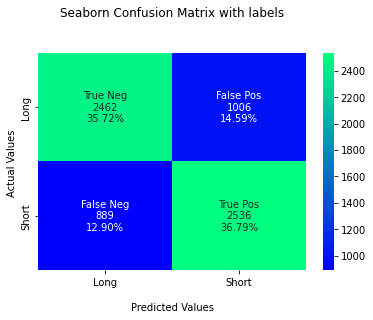

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.73      0.71      0.72      3468
           1       0.72      0.74      0.73      3425

    accuracy                           0.73      6893
   macro avg       0.73      0.73      0.73      6893
weighted avg       0.73      0.73      0.73      6893



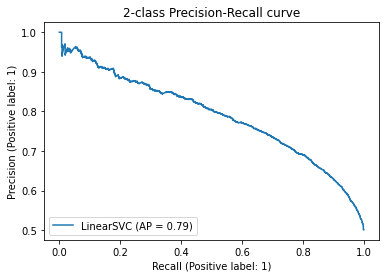

In [ ]:
evaluate("Binary Eval", best_model, stst, sp_ytest, y_hat)

This was not great but solid. I can give it a shot.

In [ ]:
spl_tr,spl_tst, spl_ytrain, spl_ytest = train_test_split(Xtr, y_binary, test_size=0.33, random_state=238)

In [ ]:
test_pred_binary = RF.predict(Xtr_test)

In [ ]:
hyperparameters= {'seed': [238], 'objective': ['binary:logistic'], 'max_depth' :[5], 'learning_rate': [0.05], 'lambda': [1.5], 'eval_metric': ['auc']}

XGB =  XGBClassifier(seed=238,max_depth=5,learning_rate=.05)

# Fit on training data
XGB = XGB.fit(Xtr, y_binary)
los_pred = XGB.predict(Xtr_test)

My results are not fantastic but they are decent. I can try to improve by cutting it differently.

In [ ]:
#Add new predictions as variable into test set
Xtr = pd.DataFrame (Xtr)
Xtr_test = pd.DataFrame(Xtr_test)

Xtr_test['LOS_binary'] = los_pred

#### Second cascade, split sets and predict on each one

In [ ]:
Xtr['LOS'] = raw_train['LOS']
trn_s = Xtr[Xtr['LOS_binary'] == 0]
trn_l = Xtr[Xtr['LOS_binary'] == 1]

#trn_s = trn_s.drop(['LOS_binary'], axis=1)
#trn_l = trn_l.drop(['LOS_binary'], axis=1)

y_s = trn_s.pop('LOS')
y_l = trn_l.pop('LOS')

#test set (need to save icustay_id for submission)
Xtr_test['icustay_id'] = raw_test['icustay_id']

tst_s = Xtr_test[Xtr_test['LOS_binary'] == 0]
tst_l = Xtr_test[Xtr_test['LOS_binary'] == 1]
#Now drop LOS from new dataframes
#tst_s = tst_s.drop(['LOS_binary'], axis=1)
#tst_l = tst_l.drop(['LOS_binary'], axis=1)

icu_s = tst_s.pop('icustay_id')
icu_l = tst_l.pop('icustay_id')

drop_LOS(Xtr)

Xtr = Xtr.drop(['LOS_binary'], axis=1)
Xtr_test = Xtr_test.drop('LOS_binary', axis=1)
Xtr_test = Xtr_test.drop('icustay_id', axis=1)

#### Randomized search with new dataframes

In [ ]:
#Ensure all columns are numeric
trn_s = trn_s.apply(pd.to_numeric)
trn_l = trn_l.apply(pd.to_numeric)
tst_s = tst_s.apply(pd.to_numeric)
tst_l = tst_l.apply(pd.to_numeric)

Below I get my XGB Parameters and then stopped the grid search

In [ ]:
models = [XGBRegressor(),
 #         DecisionTreeRegressor(),
          RandomForestRegressor()]#,
   #       AdaBoostRegressor(),
    #     GradientBoostingRegressor()]

# models parameters
xgb_params = {'objective':['reg:squarederror'],
                  'learning_rate': [0.04, .07, .1, .3],
                  'max_depth': range(1, 8),
                  'min_child_weight': [6, 7, 19],
                  'reg_lambda':[1.5, 2.8, 5],
                  'seed': [SEED]}

# dectree_params = {'max_features': range(4, 10),
#                   'max_depth': range(3, 6),
#                   'min_samples_leaf': range(5, 10),
#                   'random_state': [SEED]}

randomforest_params = {'max_features': [5, 15, 129, 750],
                  'n_estimators': [50, 100, 339],
                  'max_depth': [1, 5, 11, 23],
                  'min_samples_leaf': [3, 6, 14, 29],
                  'random_state': [SEED]}

# adab_params = {'learning_rate': [0.05, 1],
#                   'n_estimators': [50, 100],
#                   'loss':['linear', 'square'],
#                   'random_state': [SEED]}

# gb_params = {'learning_rate': [0.05, 1],
#                   'n_estimators': [50, 100],
#                   'max_depth': range(3, 6),
#                 'max_features': range(4, 20),
#                   'random_state': [SEED]}

params = [xgb_params, randomforest_params]#, adab_params, gb_params]
names = ['XGB_Regressor', 'RandomForest_Regressor']#, 'AdaBoost_Regressor',
   #     'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = RandomizedSearchCV(model, params[i], cv=4, 
                              scoring=('neg_root_mean_squared_error'))
    best_model.fit(trn_s, y_s)
    print(f"Best model fitted")
    y_hat = best_model.predict(tst_s)
    
   # mse = mean_squared_error(y, y_hat)
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)
    
    #print scores (on log parcelvalue)
    scores[names[i]] = (best_model.best_estimator_, mse)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')



```
XGB_Regressor chosen hyperparameters: {'seed': 238, 'reg_lambda': 1.5, 'objective': 'reg:squarederror', 'min_child_weight': 19, 'max_depth': 4, 'learning_rate': 0.07}
```



In [ ]:
short_preds = y_hat

In [ ]:
short_preds

array([1.2239871, 1.0097651, 1.0406079, ..., 1.2935978, 1.2505622,
       1.1627227], dtype=float32)




```
XGB_Regressor chosen hyperparameters: {'seed': 238, 'reg_lambda': 1.5, 'objective': 'reg:squarederror', 'min_child_weight': 6, 'max_depth': 6, 'learning_rate': 0.05}
XGB_Regressor MSE score on train sample: 0.12141618385399308

RandomForest_Regressor chosen hyperparameters: {'random_state': 238, 'n_estimators': 100, 'min_samples_leaf': 7, 'max_features': 9, 'max_depth': 3}
RandomForest_Regressor MSE score on train sample: 0.17248076417432215

AdaBoost_Regressor chosen hyperparameters: {'random_state': 238, 'n_estimators': 50, 'loss': 'linear', 'learning_rate': 0.05}
AdaBoost_Regressor MSE score on train sample: 0.14212843814173848

GradientBoosting_Regressor chosen hyperparameters: {'random_state': 238, 'n_estimators': 100, 'max_features': 7, 'max_depth': 5, 'learning_rate': 1}
GradientBoosting_Regressor MSE score on train sample: 0.15627161023215627

```

XGBoost wins yet again as the best performance. However adaboost regressor had a great finish in an earlier iteration, a bit behind XGBoost.


Now I predict the "long stays" test set

In [ ]:
models = [XGBRegressor(),
 #         DecisionTreeRegressor(),
          RandomForestRegressor()]#,
   #       AdaBoostRegressor(),
    #     GradientBoostingRegressor()]

# models parameters
xgb_params = {'objective':['reg:squarederror'],
                  'learning_rate': [0.04, .1, .3],
                  'max_depth': range(1, 8),
                  'min_child_weight': [6, 17, 24],
                  'reg_lambda':[.5,1.5,4],
                  'seed': [213]}

# dectree_params = {'max_features': range(4, 10),
#                   'max_depth': range(3, 6),
#                   'min_samples_leaf': range(5, 10),
#                   'random_state': [SEED]}

randomforest_params = {'max_features': [5, 15, 25, 129, 750],
                  'n_estimators': [50, 100, 139],
                  'max_depth': [1, 5, 11, 23],
                  'min_samples_leaf': [3, 6, 14, 29],
                  'random_state': [213]}

# adab_params = {'learning_rate': [0.05, 1],
#                   'n_estimators': [50, 100],
#                   'loss':['linear', 'square'],
#                   'random_state': [SEED]}

# gb_params = {'learning_rate': [0.05, 1],
#                   'n_estimators': [50, 100],
#                   'max_depth': range(3, 6),
#                 'max_features': range(4, 20),
#                   'random_state': [SEED]}

params = [xgb_params, randomforest_params]#, adab_params, gb_params]
names = ['XGB_Regressor', 'RandomForest_Regressor']#, 'AdaBoost_Regressor',
   #     'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = RandomizedSearchCV(model, params[i], cv=2, 
                              scoring=('neg_root_mean_squared_error'))
    best_model.fit(trn_l, y_l)
    print(f"Best model fitted")
    y_hat = best_model.predict(tst_l)
    
   # mse = mean_squared_error(y, y_hat)
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)
    
    #print scores (on log parcelvalue)
    scores[names[i]] = (best_model.best_estimator_, mse)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')

Grid-Searching for model XGB_Regressor...
Best model fitted
XGB_Regressor chosen hyperparameters: {'seed': 213, 'reg_lambda': 4, 'objective': 'reg:squarederror', 'min_child_weight': 24, 'max_depth': 2, 'learning_rate': 0.1}
Grid-Searching for model RandomForest_Regressor...
Best model fitted
RandomForest_Regressor chosen hyperparameters: {'random_state': 213, 'n_estimators': 100, 'min_samples_leaf': 6, 'max_features': 129, 'max_depth': 23}


In [ ]:
long_preds = y_hat

In [ ]:
# submit_s = pd.DataFrame({"icustay_id": icu_s, "LOS": short_preds})
# submit_l = pd.DataFrame({"icustay_id": icu_l, "LOS": long_preds})
# sl = pd.concat([submit_s, submit_l], ignore_index=False)
# sl = sl.set_index('icustay_id')
# #Get index to combine with
# testicu = raw_test.set_index('icustay_id')
# sl = sl.reindex(testicu.index)
# sl.to_csv('shortlong.csv', index = True)

Initial randomized search on long stays showed huge MSE scores



```
XGB_Regressor chosen hyperparameters: {'seed': 238, 'reg_lambda': 1.5, 'objective': 'reg:squarederror', 'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.05}
XGB_Regressor MSE score on train sample: 35.62470619510765


RandomForest_Regressor chosen hyperparameters: {'random_state': 238, 'n_estimators': 100, 'min_samples_leaf': 6, 'max_features': 9, 'max_depth': 4}
RandomForest_Regressor MSE score on train sample: 41.159292874038535

AdaBoost_Regressor chosen hyperparameters: {'random_state': 238, 'n_estimators': 50, 'loss': 'square', 'learning_rate': 0.05}
AdaBoost_Regressor MSE score on train sample: 38.57046761444461

GradientBoosting_Regressor chosen hyperparameters: {'random_state': 238, 'n_estimators': 100, 'max_features': 8, 'max_depth': 5, 'learning_rate': 0.05}
GradientBoosting_Regressor MSE score on train sample: 40.303467386003646
```

XGBoost is the winner followed by adaboost. 
From sklearn
> An AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.

Adaboost is great for difficult predictions and may therefore be better suited for the long stay dataset


#### Create Additional Predictions
Can skip this. Use of AdaBoost one time.

In [ ]:
# #Adaboost on large dataset
# from sklearn.ensemble import AdaBoostRegressor
# abrbx = AdaBoostRegressor(learning_rate= 0.05,
#                   n_estimators= 50,
#                   loss='square',
#                   random_state= SEED)

# y_boxl, lambda_boxl = st.boxcox(y_train_l)

# # Fit on training data with y_log in first attempt
# model = abrbx.fit(X_train_ppl, y_boxl)

# pred = model.predict(X_test_ppl)

# submission_bcx = inv_boxcox(pred, lambda_boxl)

# test_predictions_submit_l = pd.DataFrame({"icustay_id": icu_l["icustay_id"], "LOS": submission_bcx})

In [ ]:
# #XGboost on small dataset
# xgb = XGBRegressor(reg_lambda= 1.5, objective= 'reg:squarederror', min_child_weight= 6, max_depth= 6, learning_rate= 0.05)
# y_boxs, lambda_boxs = st.boxcox(y_train_s)

# # Fit on training data with y_log in first attempt
# model = xgb.fit(X_train_pps, y_boxs)

# preds = model.predict(X_test_pps)

# submission_bcxs = inv_boxcox(preds, lambda_boxs)

# test_predictions_submit_s = pd.DataFrame({"icustay_id": test_short["icustay_id"], "LOS": submission_bcxs})

My MSE did not improve

## New Split Attempt

Despite a lot of feature transformation and inspection, my estimates were not improving. I tried splitting the data in numerous ways to improve the Cascading, but I noticed that my fits were getting worse with each successive split, and my RandomForest was not good at predicting stays greater than 4 days. Predicting these very long stays is obviously the greatest challenge for the exercise and will require further investigation. 

### Preprocess

In [ ]:
x = checkpoint.drop(["subject_id",	"hadm_id",	"icustay_id", "uniquer_id"], axis = 1)

In [ ]:
x = x.drop(["LOS_deciles", "LOS_qtiles", "comorbs_bins", "LOS"], axis = 1)

In [ ]:
t = testpoint.drop(["subject_id",	"hadm_id",	"icustay_id", "uniquer_id"], axis = 1)

In [ ]:
#Will skip using this for now in favor of preprocessing pipeline
from category_encoders.hashing import HashingEncoder

h = HashingEncoder(cols=("DIAGNOSIS"), n_components = 10)

X = h.fit_transform(x, y=y_box)
t = h.transform(t)

In [ ]:
i = IterativeImputer(skip_complete=True)

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
X = X.select_dtypes(exclude=['object', 'category'])
t = t.select_dtypes(exclude=['object', 'category'])

In [ ]:
x = imp.fit_transform(X)

In [ ]:
t = imp.transform(t)

### Splitting Data Attempt

In [ ]:
q = 3
labels_binary = ['Short', 'Medium', 'Long']
X['LOS_binary'] = pd.qcut(train['LOS'], q, labels=labels_binary)

In [ ]:
X

In [ ]:
spl_train,spl_test, spl_ytrain, spl_ytest = train_test_split(X, X['LOS_binary'], test_size=0.33, random_state=238)
spl_train = spl_train.drop(["LOS_binary"], axis = 1)
spl_test = spl_test.drop(["LOS_binary"], axis = 1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Experimented a few times with parameters
RF_classifier = RandomForestClassifier(n_estimators=100, bootstrap=True)#, warm_start=True)

# Fit on training data
RF_classifier = RF_classifier.fit(spl_train, spl_ytrain)
y_pred_train = RF_classifier.predict(spl_train)
y_pred_binary = RF_classifier.predict(spl_test)

In [ ]:
print(classification_report(spl_ytest, y_pred_binary, target_names=labels_binary))

Splitting into 3 won't work. I can try again splitting into two but differently.

In [ ]:
X['LOS_binary'] = pd.cut(train['LOS'], bins=[0,2.5,100000], labels=labels_binary)


In [ ]:
X['LOS_binary'].value_counts()

In [ ]:
matrix_labels = ['Long', 'Short']

In [ ]:
spl_train,spl_test, spl_ytrain, spl_ytest = train_test_split(X, X['LOS_binary'], test_size=0.2)
spl_train = spl_train.drop(["LOS_binary"], axis = 1)
spl_test = spl_test.drop(["LOS_binary"], axis = 1)
RF_classifier = RandomForestClassifier(n_estimators=100, bootstrap=True)#, warm_start=True)

# Fit on training data
RF_classifier = RF_classifier.fit(spl_train, spl_ytrain)
y_pred_train = RF_classifier.predict(spl_train)
y_pred_binary = RF_classifier.predict(spl_test)
print(classification_report(spl_ytest, y_pred_binary, target_names=matrix_labels))

In [ ]:
cf_matrix =  confusion_matrix(spl_ytest, y_pred_binary)
cfmatrix(cf_matrix, spl_ytest, y_pred_binary, matrix_labels)

It was able to predict the short stays quite well (precision was decent), but predictably it missed the long stays

## Superlearner

In [ ]:
from sklearn.tree import ExtraTreeRegressor
!pip install mlens
from mlens.ensemble import SuperLearner

In [ ]:
Xtr_test = Xtr_test.drop('LOS_binary', axis=1)
Xtr_test = Xtr_test.drop('icustay_id', axis=1)

In [ ]:
Xtr_test = Xtr_test.drop('icustay_id', axis=1)

In [ ]:
Xtr = drop_LOS(Xtr)

Unfortunately in the below I was getting a max_features must be in (0, n_features] value_error, even though my features are in the thousands and my max_features are only 25. I'm not sure why I get this error and will need to investigate a bit further.

In [ ]:
#From tutor copy
models = [XGBRegressor(),
 #         DecisionTreeRegressor(),
          RandomForestRegressor(),
   #       AdaBoostRegressor(),
         GradientBoostingRegressor()]

from sklearn.ensemble import ExtraTreesRegressor
ex = ExtraTreesRegressor(n_estimators=100, max_features=25, bootstrap=True, warm_start=True, n_jobs=-1)
rfx = RandomForestRegressor(n_estimators=100, max_features5, bootstrap=True, random_state=SEED, n_jobs=-1, warm_start=True)
gbrx = GradientBoostingRegressor(learning_rate=0.085, n_estimators=300, random_state=SEED)

meta_learners = [ex, rfx, gbrx]

meta_learners_ = ['ExtraTrees', 'RandomForest', 'GradientBoosting']

for i, meta_learner in enumerate(meta_learners):
    super_learner = SuperLearner(folds=3, random_state=SEED)

    super_learner.add(models, proba=False)
    super_learner.add_meta(meta_learners, proba=False)
    super_learner.fit(Xtr, y)

    y_pred_tr = super_learner.predict(Xtr)    
    y_pred = super_learner.predict(Xtr_test)
    rms = mean_squared_error(y, y_pred_tr, squared=False)

    scores[f'Stacking{meta_learners_[i]}'] = (super_learner, rms)
    print(f'Super Learner with {meta_learners_[i]} RMS score on train sample: {rms}')

In [ ]:
super_learner.fit(Xtr, y)

y_pred_tr = super_learner.predict(Xtr)    
y_pred2 = super_learner.predict(Xtr_test)

NotFittedError: ignored

#### Stacking and Propagating

Good overview of ensemble methods [here](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205):

From that source: "Stacking, that often considers heterogeneous weak learners, learns them in parallel and combines them by training a meta-model to output a prediction based on the different weak models predictions"

In [ ]:
# for i, meta_learner in enumerate(meta_learners):
#     print(f'\nStackingPropagating {meta_learners_[i]}')
#     super_learner = SuperLearner(folds=2, random_state=SEED)

#     super_learner.add(models, propagate_features=pointer, proba=True)
#     super_learner.add_meta(meta_learner, proba=False)
#     super_learner.fit(Xtr, y)
    
#     y_pred_tr = super_learner.predict(Xtr_test)
#     roc_auc_tr = roc_auc_score(y_train, y_pred_tr)
 
#     y_pred = super_learner.predict_proba(Xtr_test)
#     scores[f'StackingPropagating{meta_learners_[i]}'] = (super_learner, roc_auc)
    
#     print(f'Super Learner with {meta_learners_[i]} MSE on train sample: {roc_auc_tr}')


# Neural Networks

I ended up just runnning a model with Keras instead of Pytorch. The Neural Network tends to overfit and requires a bit more tuning, so I didn't have time to investigate this fully. However, I did run one model below. My MSE indicated in the epochs indicated that this was not worth hugely prioritizing over the XGboost.

In [ ]:
! pip install tensorflow
! pip install mnist

In [ ]:
from sklearn.metrics import accuracy_score
import os
import tarfile
import imageio
import tqdm
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Device configuration
print(torch.cuda.is_available())

False


#### Scale and Preprocess Data
Scaling is helpful for the neural networks, so I want to ensure I scale the data, which was not as important for the trees.

In [ ]:
checkpoint2 = checkpoint2.drop(columns=['PNEUMONIA', 'CARDIAC'])
testpoint2 = testpoint2.drop(columns=['PNEUMONIA', 'CARDIAC'])

In [ ]:
trainN = checkpoint2.copy()
cat_feat = trainN.select_dtypes(include=['object', 'category']).columns
icd9_feat = ['ICD9_diagnosis']
cat_feat = cat_feat.drop(['ICD9_diagnosis']) 
print(icd9_feat)
print(cat_feat)
cont_imputer = SimpleImputer(strategy="most_frequent")
it_imputer = IterativeImputer(missing_values=np.nan)
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
cont_scaler = RobustScaler()
cat_scaler = StandardScaler()

y_trainNdf = trainN.filter(items=["LOS"])
y_trainN = trainN['LOS'] 
X_trainN = trainN.drop(["LOS", "LOS_qtiles","LOS_deciles", "comorbs_bins", "subject_id", "hadm_id",  "icustay_id", "uniquer_id"], axis = 1)

# Update list of numerical and categorical features
num_feat = X_trainN.select_dtypes(exclude=['object', 'category']).columns
print(num_feat)

cat_feat = X_trainN.select_dtypes(include=['object', 'category']).columns

# make own category for preprocessing 'ICD9_diagnosis'
icd9_feat = ['ICD9_diagnosis']
cat_feat = cat_feat.drop(['ICD9_diagnosis']) 
print(icd9_feat)
print(cat_feat)

#Commenting out scalers as not necessary

# pipeline for numerical data
num_preprocessing = make_pipeline(
    cont_scaler,
    it_imputer   
    )

# pipeline for categorical data
cat_preprocessing = make_pipeline(
    cont_imputer, # we only have missing data now in the continious 
    cat_encoder,
    cat_scaler)
    
import category_encoders as ce

icd9_encoder = LeaveOneOutEncoder(sigma=.35, drop_invariant=True) #Tune sigma for overfitting
icd9_preprocessing = make_pipeline(
    icd9_encoder,
    cat_scaler)


# combine preprocessing pipelines using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_feat),
     ("cat", cat_preprocessing, cat_feat),
     ("icd9", icd9_preprocessing, icd9_feat)
     ]
  # ,remainder='passthrough')
     ,remainder='drop')

from sklearn import set_config
set_config(display="diagram")
preprocessing

preprocessing.fit(X_trainN, y_trainN)
X_train_ppN = preprocessing.transform(X_trainN)

X_test = testpoint2.drop(["subject_id", "hadm_id",  "icustay_id", "uniquer_id"], axis = 1)

X_test_ppN = preprocessing.transform(X_test)


['ICD9_diagnosis']
Index(['GENDER', 'INSURANCE', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'ADMITBINS',
       'LOS_deciles', 'LOS_qtiles', 'comorbs_bins'],
      dtype='object')
Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'ADMITTIME', 'ADMISSION_TYPE', 'AGE', 'visit_cmbs',
       'HeartRate_Range', 'SysBP_Range', 'DiasBP_Range', 'MeanBP_Range',
       'RespRate_Range', 'TempC_Range', 'SpO2_Range', 'Glucose_Range',
       'PulsePressure_Min', 'PulsePressure_Mean', 'PulsePressure_Max',
       'PulsePressure_Range', 'HeartRateMax_Age', 'repeat',
       'SUBARACHNOID HEMORRHAGE', 'CEREBRAL'],
      dtype='object')
['ICD9_diagnosis']
Index(['GENDER', 'INSURAN

In [ ]:
from sklearn import set_config
set_config(display="diagram")
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler()),
                                                 ('iterativeimputer',
                                                  IterativeImputer())]),
                                 Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'T...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['GENDER', 'INSURANCE', 'DIAGNOSIS', 'FIRST_CAREUNIT'], dtype='object')),
                                ('icd9',
                                 Pipeline(steps=[('leaveoneoutencoder',
                                                  LeaveOneOutEncoder(drop_invariant=True,
                                                                     sigma=0.35)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['ICD9_diagnosis'])])

### Run model

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf

Keras_MLP = Sequential([
  Dense(64, activation='relu', input_shape=(6250,)),
  Dense(64, activation='relu'),
  Dense(10, activation='softmax'),
])

Keras_MLP.compile(
  optimizer='adam',
  loss='mse',
   metrics=[tf.keras.metrics.RootMeanSquaredError()], #using root mean squared error as in Kaggle
)

Keras_MLP.fit(
  X_train_ppN,
  y,
  epochs=10,
  batch_size=32,
)

Epoch 1/5
653/653 [==============================] - 2s 3ms/step - loss: 39.7551 - root_mean_squared_error: 6.3052
Epoch 2/5
653/653 [==============================] - 2s 3ms/step - loss: 39.7544 - root_mean_squared_error: 6.3051
Epoch 3/5
653/653 [==============================] - 2s 3ms/step - loss: 39.7544 - root_mean_squared_error: 6.3051
Epoch 4/5
653/653 [==============================] - 2s 3ms/step - loss: 39.7543 - root_mean_squared_error: 6.3051
Epoch 5/5
653/653 [==============================] - 2s 3ms/step - loss: 39.7544 - root_mean_squared_error: 6.3051


In [ ]:
p_hat_test = Keras_MLP.predict(X_test_ppN)
na = np.array(p_hat_test)
sub = na[:,4]

In [ ]:
#submission_nn = inv_boxcox(sub, lambda_box)

test_predictions_submit_nn = pd.DataFrame({"icustay_id": test["icustay_id"], "LOS":sub})
test_predictions_submit_nn.to_csv("nn_firsttry.csv", index = False)

In [ ]:
history = Keras_MLP.fit(
  X_train_ppN,
  y,
  epochs=10,
  batch_size=32,
)

Epoch 1/10
653/653 [==============================] - 2s 3ms/step - loss: 39.7543 - root_mean_squared_error: 6.3051
Epoch 2/10
653/653 [==============================] - 2s 3ms/step - loss: 39.7543 - root_mean_squared_error: 6.3051
Epoch 3/10
653/653 [==============================] - 2s 3ms/step - loss: 39.7543 - root_mean_squared_error: 6.3051
Epoch 4/10
653/653 [==============================] - 2s 3ms/step - loss: 39.7543 - root_mean_squared_error: 6.3051
Epoch 5/10
653/653 [==============================] - 2s 3ms/step - loss: 39.7543 - root_mean_squared_error: 6.3051
Epoch 6/10
653/653 [==============================] - 2s 3ms/step - loss: 39.7543 - root_mean_squared_error: 6.3051
Epoch 7/10
653/653 [==============================] - 2s 3ms/step - loss: 39.7544 - root_mean_squared_error: 6.3051
Epoch 8/10
653/653 [==============================] - 2s 3ms/step - loss: 39.7543 - root_mean_squared_error: 6.3051
Epoch 9/10
653/653 [==============================] - 2s 3ms/step - loss

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error'])


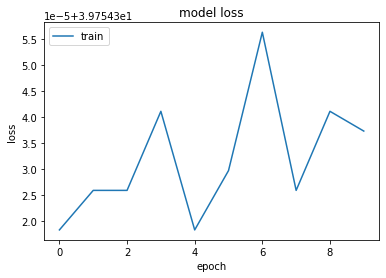

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Will need to run more epochs

# APPENDIX

Here I included some bits of code and images that I thought of but didn't meaningfully contribute to the notebook.

## Categorical Encoding Methods

I used this to come to the conclusion that I should try the LeaveOneOutEncoder.
From this link: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

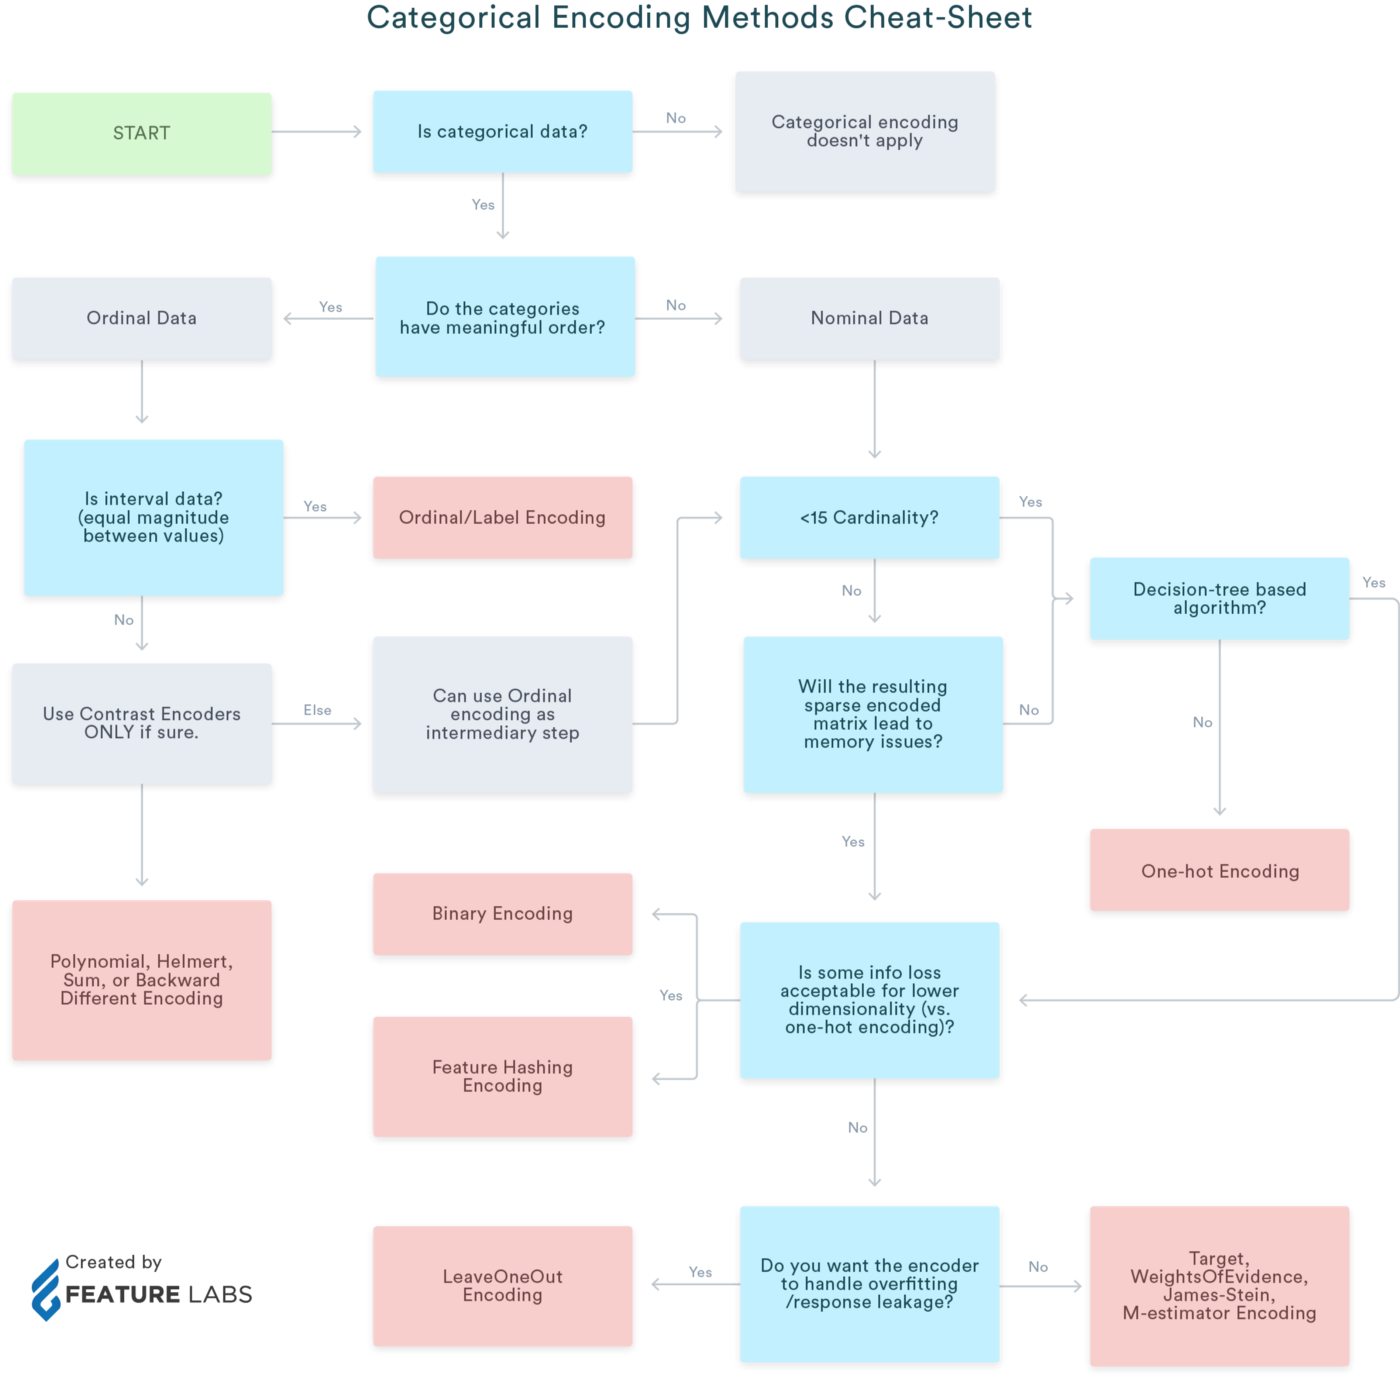

### Text Evaluation

Here I evaluate the text in the DFs. In further application, it could be interesting to predict LOS using text analysis for the long form diagnoses.

In [ ]:
#Inspect
cmbs.nunique()

subject_id        46520
hadm_id           58976
seq_num              39
icd9_code          6984
uniquer_id        58976
short_diagnose     6770
long_diagnose      6839
visit_cmbs           40
dtype: int64

The number of unique short_diagnoses does not match perfectly with the icd9_code, but it is close enough

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse

#### Unigrams

In [ ]:
strings = cmbs['long_diagnose'].astype(str)


vectorizer = CountVectorizer(stop_words='english', lowercase=True)
cv_matrix = vectorizer.fit_transform(strings)
#Turn sparse matrix back into a dataframe 
sparse = pd.DataFrame.sparse.from_spmatrix(cv_matrix, columns=vectorizer.get_feature_names())

In [ ]:
df_dtm = pd.concat([cmbs, sparse], axis=1)
df_dtm = df_dtm.drop(columns=['seq_num', 'short_diagnose', 'long_diagnose'])
df_dtm.groupby(by=['subject_id', 'hadm_id'])
sums = sparse.sum(axis=0)
sums = sums.sort_values(axis=0, ascending=False)
sums.head(50)

unspecified        184008
mention             46761
chronic             45525
acute               42352
failure             41688
type                38453
disease             34300
kidney              34298
coronary            31752
heart               27503
specified           25440
classified          24904
hypertension        22868
essential           21666
complication        20956
use                 18993
history             18919
malignant           18654
neoplasm            18541
diabetes            18490
stage               17247
personal            17036
atherosclerosis     16670
uncontrolled        16580
nan                 16338
artery              16028
anemia              15911
infection           15756
native              15311
atrial              14776
site                14500
infarction          14299
ii                  14244
stated              14090
hemorrhage          13711
congestive          13567
fibrillation        13459
status              13392
disorder    

#### Bigrams

In [ ]:
vectorizer = CountVectorizer(stop_words='english', lowercase=True, ngram_range=(2, 2))
cv_matrix = vectorizer.fit_transform(strings)
#Turn sparse matrix back into a dataframe 
sparse = pd.DataFrame.sparse.from_spmatrix(cv_matrix, columns=vectorizer.get_feature_names())
sums = sparse.sum(axis=0)
sums = sums.sort_values(axis=0, ascending=False)
sums.head(50)

failure unspecified           23585
essential hypertension        21334
heart failure                 21302
unspecified essential         20703
kidney disease                19211
chronic kidney                19171
unspecified type              17683
malignant neoplasm            17095
personal history              17035
coronary atherosclerosis      14440
stated uncontrolled           14071
type stated                   13958
atherosclerosis native        13817
type ii                       13652
ii unspecified                13606
congestive heart              13111
atrial fibrillation           12891
coronary artery               12822
native coronary               12429
mention complication          12112
acute kidney                  11475
kidney failure                11475
disease unspecified           11450
diabetes mellitus             10187
mellitus mention               9965
complication type              9955
respiratory failure            8703
unspecified hyperlipidemia  

This is interesting! But it might be better to run this on the short diagnose, for computational sake. It's also slightly odd that there is a category labeled 'Misadventure Time'. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse

print("Unigrams for Short Diagnoses")
short_strings = cmbs['short_diagnose'].astype(str)
vectorizer2 = CountVectorizer(stop_words='english', lowercase=True)
cv_matrix2 = vectorizer2.fit_transform(short_strings)
#Turn sparse matrix back into a dataframe 
sparse2 = pd.DataFrame.sparse.from_spmatrix(cv_matrix2, columns=vectorizer2.get_feature_names())
short_sums = sparse2.sum(axis=0)
short_sums = short_sums.sort_values(axis=0, ascending=False)
print(short_sums.head(25))
print(" ")
print("Bigrams for Short Diagnoses")
vectorizer3 = CountVectorizer(stop_words='english', lowercase=True, ngram_range=(2, 2))
cv_matrix2 = vectorizer3.fit_transform(short_strings)
#Turn sparse matrix back into a dataframe 
sparse3 = pd.DataFrame.sparse.from_spmatrix(cv_matrix2, columns=vectorizer3.get_feature_names())
short_sums2 = sparse3.sum(axis=0)
short_sums2 = short_sums2.sort_values(axis=0, ascending=False)
print(short_sums2.head(25))

Unigrams for Short Diagnoses
nos             161017
nec              77747
dis              27025
hypertension     22792
acute            21380
failure          20591
chr              19866
kidney           17666
ac               17146
nan              16338
anemia           16037
disorder         14981
atrial           14963
wo               14883
hx               14619
st               14564
nt               14261
use              13912
dmii             13606
fibrillation     13459
chf              13111
kid              12899
crnry            12429
athrscl          12429
natve            12429
dtype: int64
 
Bigrams for Short Diagnoses
hypertension nos       20703
nt st                  14071
nec nos                13580
chf nos                13111
atrial fibrillation    12891
athrscl natve          12429
natve vssl             12429
crnry athrscl          12429
failure nos            10364
wo cmp                  9960
dmii wo                 9512
cmp nt                  9482
kidne

The short bigrams are not nearly as interesting as they are difficult to understand. 

Although Count Vectorizer is great, it's computationally burdensome. I can instead try to use the Hash Encoder from sklearn later on

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html 

Glancing through the student solutions, I thought this was a nice trick from Andres Couble. Although you would expect the algorithm to pick up on how ICD9_Codes impact death it will still be an interesting feature to have.

In [ ]:
train.groupby('ICD9_diagnosis').mean().sort_values(by="HOSPITAL_EXPIRE_FLAG").tail(20)

### Skewness and Class Imbalance

We tend to think of class imbalance as only being relevant for classification problems, however I came across research at MIT looking into imbalanced regression. http://dir.csail.mit.edu/ with an acocmpanying Github Repo. https://github.com/YyzHarry/imbalanced-regression 

Note imbalance and skewness are not one and the same. See diagrams in link above. Although I did not attempt to make predictions to correct for this other than Box-Coxing my y variable, I think this could be worth exploring in the future.


